# Poço Quadrado Finito

Neste documento demonstramos a utilização do software e indicamos os resultados, que podem ser visualizados no modo abaixo ou acessados na pasta **saidas**.

## Bibliotecas utilizadas

In [1]:
# python standard
import time

# third-party
import pandas as pd
import numpy as np
import scipy.constants as cte
from scipy.integrate import simps
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.optimize import newton

## Configurações gráficas

In [2]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('mestrado')

## Classe que simula um poço

In [3]:
class PocoQuantico(object):
    """Simula um poço quântico"""


    def __init__(self, well_length=100.0, well_height=1.0, N=2048, 
            dt=1e-19, surround=1):
        """Construtor
        
        Parametros
        ----------
        well_length : float
            a largura do poço em angstrom
        well_height: float
            a altura do poço em eV
        N : int
            o número de pontos para a malha espacial
        dt : float
            o passo de tempo em segundos
        surround : int
            quantas vezes a largura do poço é utilizada para formar as
            barreiras. Por exemplo, para um poço de largura
            100.0 Angstrom, surround=1 significa que será adicionado ao
            sistema mais 100.0 Angstrom de cada lado, constituindo um
            sistema de largura total 300.0 Angstrom. Para o mesmo poço,
            surround=2, seria adicionado ao sistema 200.0 Angstrom de
            cada lado, totalizando um sistema de 500.0 Angstrom
        """

        # unidades atômicas
        self.au_l = cte.value('atomic unit of length')
        self.au_t = cte.value('atomic unit of time')
        self.au_e = cte.value('atomic unit of energy')

        # outras constantes de interesse
        self.ev = cte.value('electron volt')
        self.au2ang = self.au_l / 1e-10
        self.au2ev = self.au_e / self.ev

        # massa efetiva constante
        self.m_eff = 1.0

        # cria um dispositivo
        self.set_device(well_length, well_height, N, dt, surround)

    def set_device(self, well_length=100.0, well_height=1.0, N=2048, 
            dt=(1e-19), surround=1):
        """Ajusta as propriedades do dispositivo mesmo depois de criado
        
        Parametros
        ----------
        well_length : float
            a largura do poço em angstrom
        well_height: float
            a altura do poço em eV
        N : int
            o número de pontos para a malha espacial
        dt : float
            o passo de tempo em segundos
        surround : int
            quantas vezes a largura do poço é utilizada para formar as
            barreiras. Por exemplo, para um poço de largura
            100.0 Angstrom, surround=1 significa que será adicionado ao
            sistema mais 100.0 Angstrom de cada lado, constituindo um
            sistema de largura total 300.0 Angstrom. Para o mesmo poço,
            surround=2, seria adicionado ao sistema 200.0 Angstrom de
            cada lado, totalizando um sistema de 500.0 Angstrom
        
        Retorno
        -------
        O próprio objeto para uso em chamadas em cadeia
        """
        self.well_length = W = well_length
        self.well_height = well_height
        self.vb_au = well_height / self.au2ev
        self.wl_au = well_length / self.au2ang
        
        self.device_length = L = (1.0 + 2.0 * surround) * well_length
        self.N = N
        self.z_ang = np.linspace(-L/2.0, L/2.0, self.N)
        self.z_au = self.z_ang / self.au2ang
        self.dz_au = np.abs(self.z_au[1] - self.z_au[0])

        potential = np.vectorize(lambda z: 0.0 if np.abs(z) < W/2 
            else well_height)
        self.v_ev = potential(self.z_ang)
        self.v_au = self.v_ev / self.au2ev

        # ajusta o passo de tempo
        return self._set_time(dt)
    
    def solucao_analitica(self):
        """Calcula os estados ligados do sistema resolvendo as
        equações transcendentais
        
        Retorno
        -------
        Uma lista com os autovalores
        """
        import warnings
        warnings.filterwarnings('error')
        eigenvalues = []
        
        # tan(k_w . L / 2) = k_b / k_w
        # cot(k_w . L / 2) = - k_b / k_w
        trans_tan = lambda e: np.tan(
                np.sqrt(2*self.m_eff*e)*self.wl_au/2
            ) - np.sqrt(self.vb_au/e - 1.0)

        trans_tan_der = lambda e: 1.0 / np.cos(
                np.sqrt(2*self.m_eff*e)*self.wl_au/2
            )**2 * (
                self.m_eff * self.wl_au / (2 * np.sqrt(2*self.m_eff*e))
            ) + self.vb_au / (2.0 * e**2 * np.sqrt(self.vb_au/e - 1.0))

        trans_cot = lambda e: 1.0 / np.tan(
                np.sqrt(2*self.m_eff*e)*self.wl_au/2
            ) + np.sqrt(self.vb_au/e - 1.0)

        trans_cot_der = lambda e: -1.0 / np.sin(
                np.sqrt(2*self.m_eff*e)*self.wl_au/2
            )**2 * (
                self.m_eff * self.wl_au / (2 * np.sqrt(2*self.m_eff*e))
            ) - self.vb_au / (2.0 * e**2 * np.sqrt(self.vb_au/e - 1.0))

        t_functions = [
            (trans_tan,trans_tan_der),
            (trans_cot, trans_cot_der)
        ]

        # chutes de energia iniciais
        energies = np.linspace(-0.1*self.vb_au, 1.1*self.vb_au, 10000)
        
        for f,fp in t_functions:
            for e0 in energies:
                try:
                    root = newton(f, x0=e0, fprime=fp)
                    if root > 0:
                        eigenvalues.append(root * self.au2ev)
                except:
                    pass
                    
        eigenvalues = np.array(list(sorted(set(eigenvalues))))
        
        # os autovalores neste momento estão em uma grande list com
        # 2000 elementos, muitos são repetidos, devido aos chutes
        # iniciais próximos convergirem para o mesmo resultado
        # o algoritmo abaixo identifica aqueles que estão em um
        # intervalo muito próximo
        offset = [0]
        for i in range(1, eigenvalues.size):
            if np.abs(eigenvalues[i] / \
                    np.average(eigenvalues[offset[-1]:i])-1.0) > 0.01:
                offset.append(i)
        offset.append(len(eigenvalues))
        eigenvalues = [np.average(eigenvalues[offset[i]:offset[i+1]]) \
            for i in range(len(offset)-1)]
        return eigenvalues

    def evolucao_imaginaria(self, nmax=None, precision=1e-4, 
            iterations=None, max_time=None, reset=False):
        """CCalcula os estados ligados do sistema utilizando um método
        numérico (Pseudo-Espectral: Split-Step FFT)
        
        Parâmetros
        ----------
        nmax : int
            o número de estados ligados a serem gerados
        precision : float
            a precisão numérica aceita
        iterations : int
            o número máximo de iterações
        max_time : float
            o tempo máximo de processamento por nível de energia
        reset : boolean
            se verdadeiro, reinicia o sistema, caso contrário continua
            evoluindo um sistema que já começou a ser evoluído
            anteriormente, mas que foi interrompido por, por exemplo,
            ultrapassa o número máximo de iterações
        
        Retorno
        -------
        O próprio objeto para uso em chamadas em cadeia
        """

        # seleciona o modo tempo imaginário
        self._set_time(imaginary=True)
        analytic_values = self.solucao_analitica()
        if nmax:
            nmax = min(nmax, len(analytic_values))
        else:
            nmax = len(analytic_values)

        if reset or not hasattr(self, 'eigenvalues'):
            # inicializa os autovalores como zero
            self.eigenvalues = np.zeros(nmax)
            short_grid = np.linspace(-1, 1, self.N)

            # inicializa os autovetores como polinômios de legendre
            # multiplicados por uma gaussiana
            g = gaussian(self.N, std=int(self.N/100))
            self.eigenstates = np.array([g*legendre(i)(short_grid) 
                for i in range(nmax)],dtype=np.complex_)
            
            # os contadores vão armazenar o máximo de iterações por
            # estado
            self.counters = np.zeros(nmax, dtype=np.int32)

            # os timers vão salvar o tempo que cada estado leva
            self.timers = np.zeros(nmax)

            # salva a precisão obtida em cada autoestado
            self.eigenvalues_precisions = np.zeros(nmax)

            # salva a precisão obtida em cada autovalor
            self.eigenstates_precisions = np.zeros(nmax)

        
        # split step
        for s in range(nmax):
            while True:
                # começa a contar o tempo aqui
                start_time = time.time()
                self.eigenstates[s] = \
                    self.evolution_operator(self.eigenstates[s])
                self.counters[s] += 1
                
                # gram-schmidt
                for m in range(s):
                    proj = simps(self.eigenstates[s] * \
                        self.eigenstates[m].conj(), self.z_au)
                    self.eigenstates[s] -= proj * self.eigenstates[m]
                    
                # normaliza
                A = np.sqrt(simps(np.abs(self.eigenstates[s])**2, 
                    self.z_au))
                self.eigenstates[s] /= A
                self.timers[s] += time.time() - start_time
                
                if (iterations and self.counters[s] >= iterations) \
                    or (max_time and self.timers[s] >= max_time) \
                    or self.counters[s] % 1000 == 0:
                    # derivada segunda
                    derivative2 = (self.eigenstates[s][:-2] - \
                        2 * self.eigenstates[s][1:-1] + \
                        self.eigenstates[s][2:]) / self.dz_au**2
                    psi = self.eigenstates[s][1:-1]
                    # <Psi|H|Psi>
                    p_h_p = simps(psi.conj() * (-0.5 * derivative2 / \
                        self.m_eff + self.v_au[1:-1] * psi), \
                        self.z_au[1:-1])
                    # divide por <Psi|Psi> 
                    #p_h_p /= A**2

                    value_before = self.eigenvalues[s] or 1.0
                    self.eigenvalues[s] = p_h_p.real * self.au2ev # eV
                    self.eigenvalues_precisions[s] = np.abs(1.0 - \
                    #    self.eigenvalues[s] / analytic_values[s])
                        self.eigenvalues[s] / value_before)
                    
                    if (iterations and self.counters[s] >= iterations) \
                        or (max_time and self.timers[s] >= max_time) \
                        or (not iterations and not max_time and \
                        self.eigenvalues_precisions[s] < precision) \
                        or self.counters[s] > 300000: # hard code
                        
                        print("""Energy [{}]:
                                Numeric={:.10e}
                                Analytic={:.10e}
                                iterations={}""".format(s, self.eigenvalues[s],
                                                       analytic_values[s],
                                                       self.counters[s]))
                        
                        break

        return self

    def _set_time(self, dt=None, imaginary=False):
        """Ajusta o tempo para real e imaginário, além de acertar o
        passo de empo
        
        Parâmetros
        ----------
        dt : float
            o tempo em segundos
        imaginary : boolean
            verdadeiro para utilizar tempo imaginário e falso para
            tempo real
        
        Retorno
        -------
        O próprio objeto para uso em chamadas em cadeia
        """

        self.dt = dt or self.dt
        self.dt_au = self.dt / self.au_t
        if imaginary:
            self.dt_au *= -1.0j
        

        # # split step
        self.k_au = fftfreq(self.N, d=self.dz_au)
        self.exp_v2 = np.exp(-0.5j * self.v_au * self.dt_au)
        self.exp_t = np.exp(-0.5j * (2 * np.pi * self.k_au) ** 2 * \
            self.dt_au / self.m_eff)
        self.evolution_operator = lambda p: self.exp_v2 * \
            ifft(self.exp_t * fft(self.exp_v2 * p))
        
        return self

## Inicia um poço quântico

In [4]:
poco_100 = PocoQuantico(well_length=100.0, well_height=1.0, N=2048, dt=1e-18)

Este é o potencial que vamos usar:

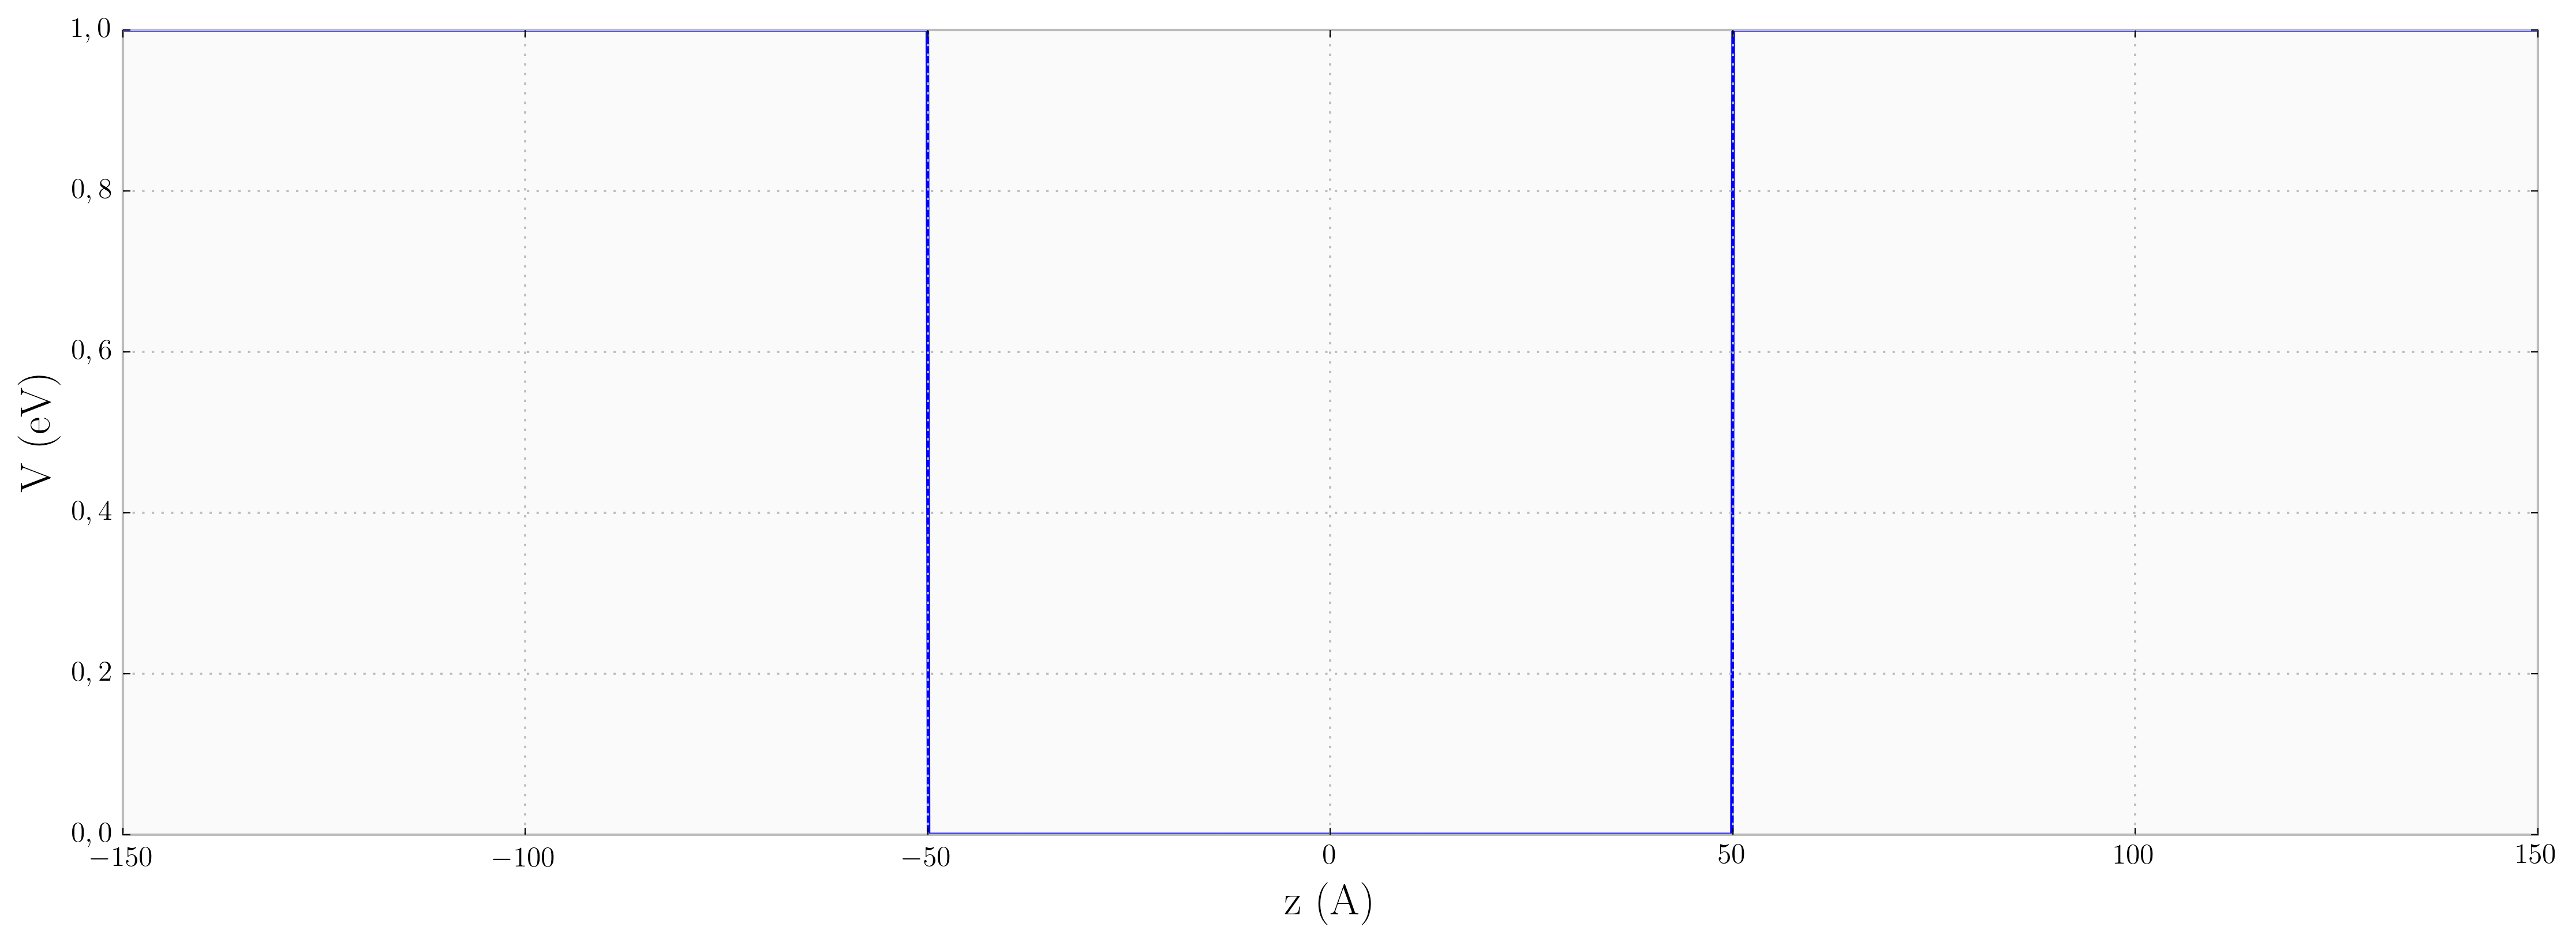

In [5]:
fix, ax = plt.subplots(1,1, figsize=(18,6))
ax.plot(poco_100.z_ang, poco_100.v_ev)
ax.set_xlabel(r'z (A)')
ax.set_ylabel(r'V (eV)')
plt.show()

que foi iniciado com as seguintes propriedades:

- **well_length=100.0**, largura de 100.0 Angstrom
- **well_height=1.0**, altura de 1.0 eV
- **N=2048**, 2048 pontos na malha (discretização)
- **dt=1e-19**, passo de tempo de $1 \times 10^{-18}$ segundos

## Calculo dos Autoestados e Autovalores

O comando abaxo solicita o cálculo dos autoestados e autovalores com precisao de 0.01 %.

Está precisão não é em relação ao valor analítico, mas em relação ao valor para o qual o algoritmo convergiu (que possui um erro em relação ao analítico).

In [6]:
poco_100.evolucao_imaginaria(precision=1e-4)

Energy [0]:
                                Numeric=3.4898948254e-03
                                Analytic=3.4828963796e-03
                                iterations=104000
Energy [1]:
                                Numeric=1.3951814274e-02
                                Analytic=1.3929748482e-02
                                iterations=76000
Energy [2]:
                                Numeric=3.1373388323e-02
                                Analytic=3.1334961728e-02
                                iterations=48000
Energy [3]:
                                Numeric=5.5750644769e-02
                                Analytic=5.5688922460e-02
                                iterations=41000
Energy [4]:
                                Numeric=8.7064283660e-02
                                Analytic=8.6977528175e-02
                                iterations=31000
Energy [5]:
                                Numeric=1.2528953568e-01
                                Analytic=1.2518144

Como é possível ver acima (clique na tela para rolar) temos 17 autoestados, com autovalores:

In [7]:
print(poco_100.eigenvalues)

[ 0.00348989  0.01395181  0.03137339  0.05575064  0.08706428  0.12528954
  0.17042459  0.22240967  0.28119866  0.34675937  0.41898721  0.49778468
  0.58299325  0.67429257  0.77127282  0.87295473  0.97561505]


Os autovalores analíticos são:

In [8]:
poco_100.analytical_eigenvalues = np.array(poco_100.solucao_analitica())
print(poco_100.analytical_eigenvalues)

[ 0.0034829   0.01392975  0.03133496  0.05568892  0.08697753  0.12518145
  0.17027502  0.22222458  0.28098598  0.34650064  0.41868927  0.4974408
  0.58259197  0.67388421  0.77085693  0.87249409  0.97487074]


Vamos ver o erro em cada autovalor:

In [9]:
eigenvalues = pd.DataFrame({'analytic': poco_100.analytical_eigenvalues, 'numeric': poco_100.eigenvalues})
eigenvalues['error (%)'] = eigenvalues.apply(lambda l: 100.0*(l['numeric']/l['analytic']-1.0), axis=1)
print(eigenvalues)

    analytic   numeric  error (%)
0   0.003483  0.003490   0.200938
1   0.013930  0.013952   0.158408
2   0.031335  0.031373   0.122632
3   0.055689  0.055751   0.110834
4   0.086978  0.087064   0.099745
5   0.125181  0.125290   0.086344
6   0.170275  0.170425   0.087840
7   0.222225  0.222410   0.083290
8   0.280986  0.281199   0.075690
9   0.346501  0.346759   0.074668
10  0.418689  0.418987   0.071161
11  0.497441  0.497785   0.069128
12  0.582592  0.582993   0.068879
13  0.673884  0.674293   0.060598
14  0.770857  0.771273   0.053951
15  0.872494  0.872955   0.052796
16  0.974871  0.975615   0.076349


Vamos imprimir os autoestados:

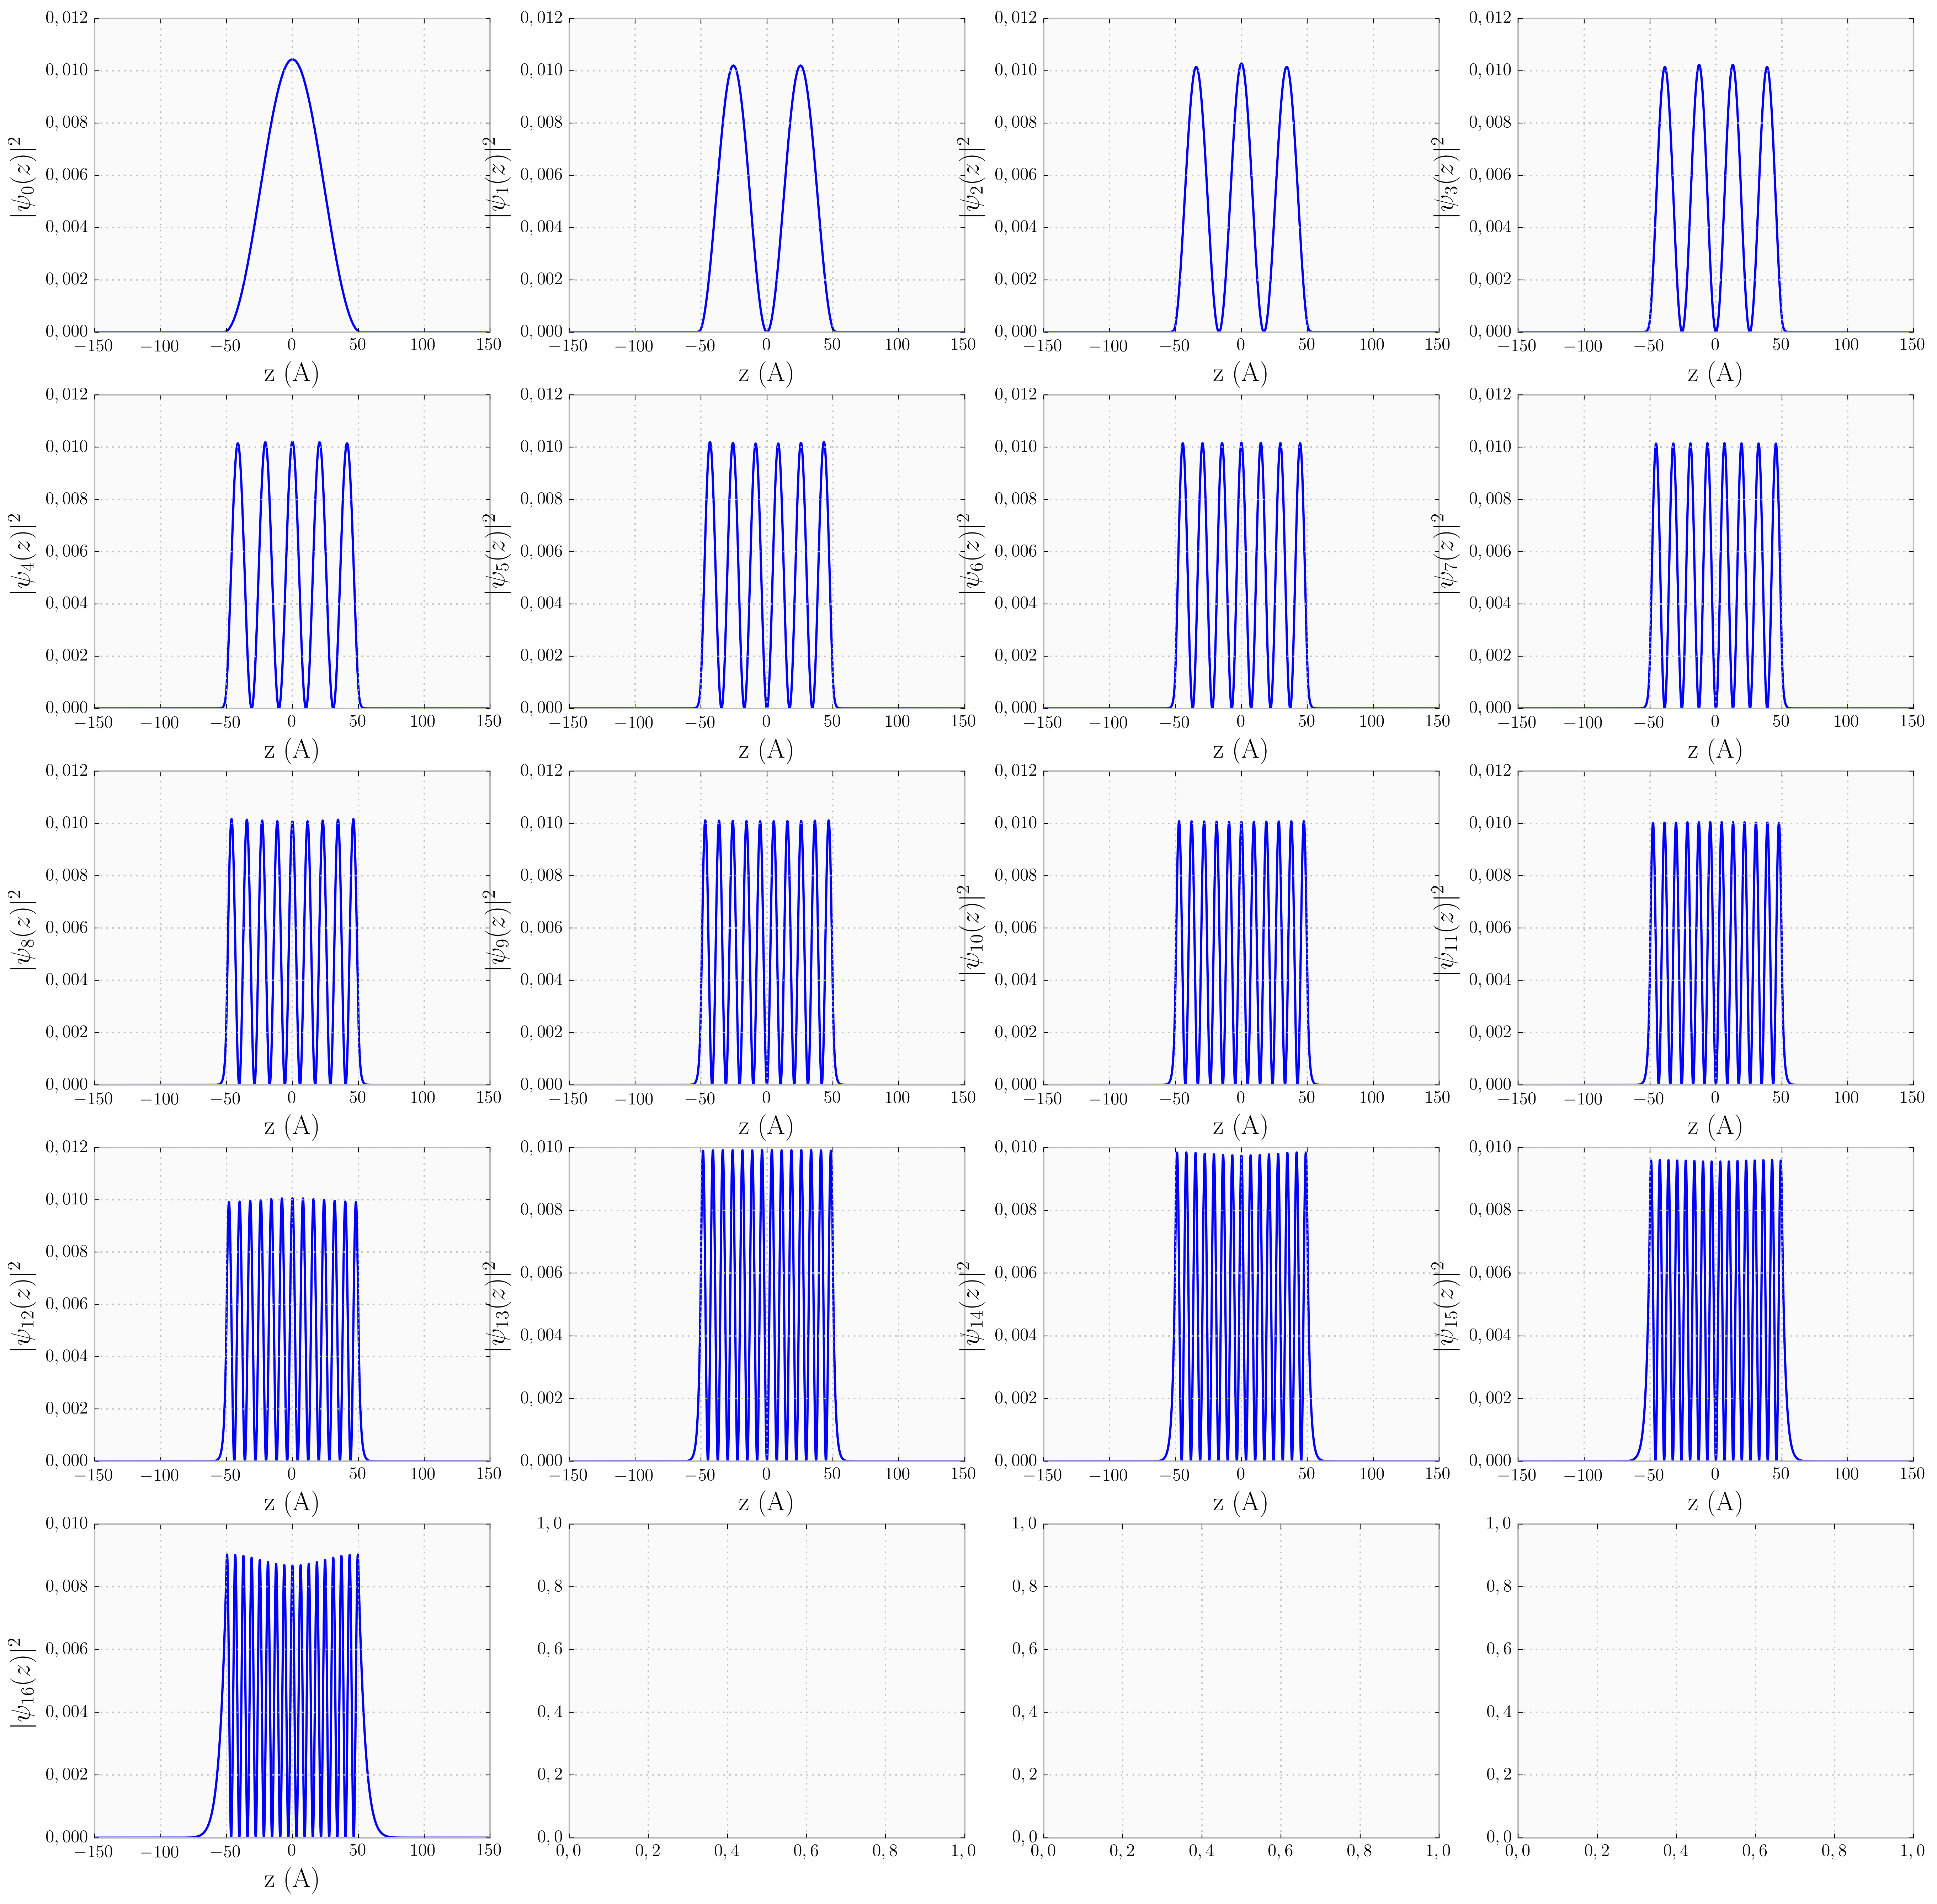

In [10]:
fix, axs = plt.subplots(5,4, figsize=(22,22))
for i in range(5):
    for j in range(4):
        if (4*i+j) >= len(poco_100.eigenstates):
            continue
        axs[i,j].plot(poco_100.z_ang, np.abs(poco_100.eigenstates[4*i+j])**2)
        axs[i,j].set_xlabel(r'z (A)')
        axs[i,j].set_ylabel(r'$|\psi_{%d} (z)|^2$' % (4*i+j))
plt.show()

Estes autoestados estão normalizados para um eixo **z** em unidades atômicas, vamos normalizar eles para um eixo **z** em Angstrom:

In [11]:
z = poco_100.z_ang
def normalize2ang(psi):
    # psi / (<psi|psi>)^(1/2)
    return psi / np.sqrt(simps(psi.conj()*psi,z))
poco_100.eigenstates_ang = [normalize2ang(es) for es in poco_100.eigenstates]

vamos imprimir para ver que está tudo certo:

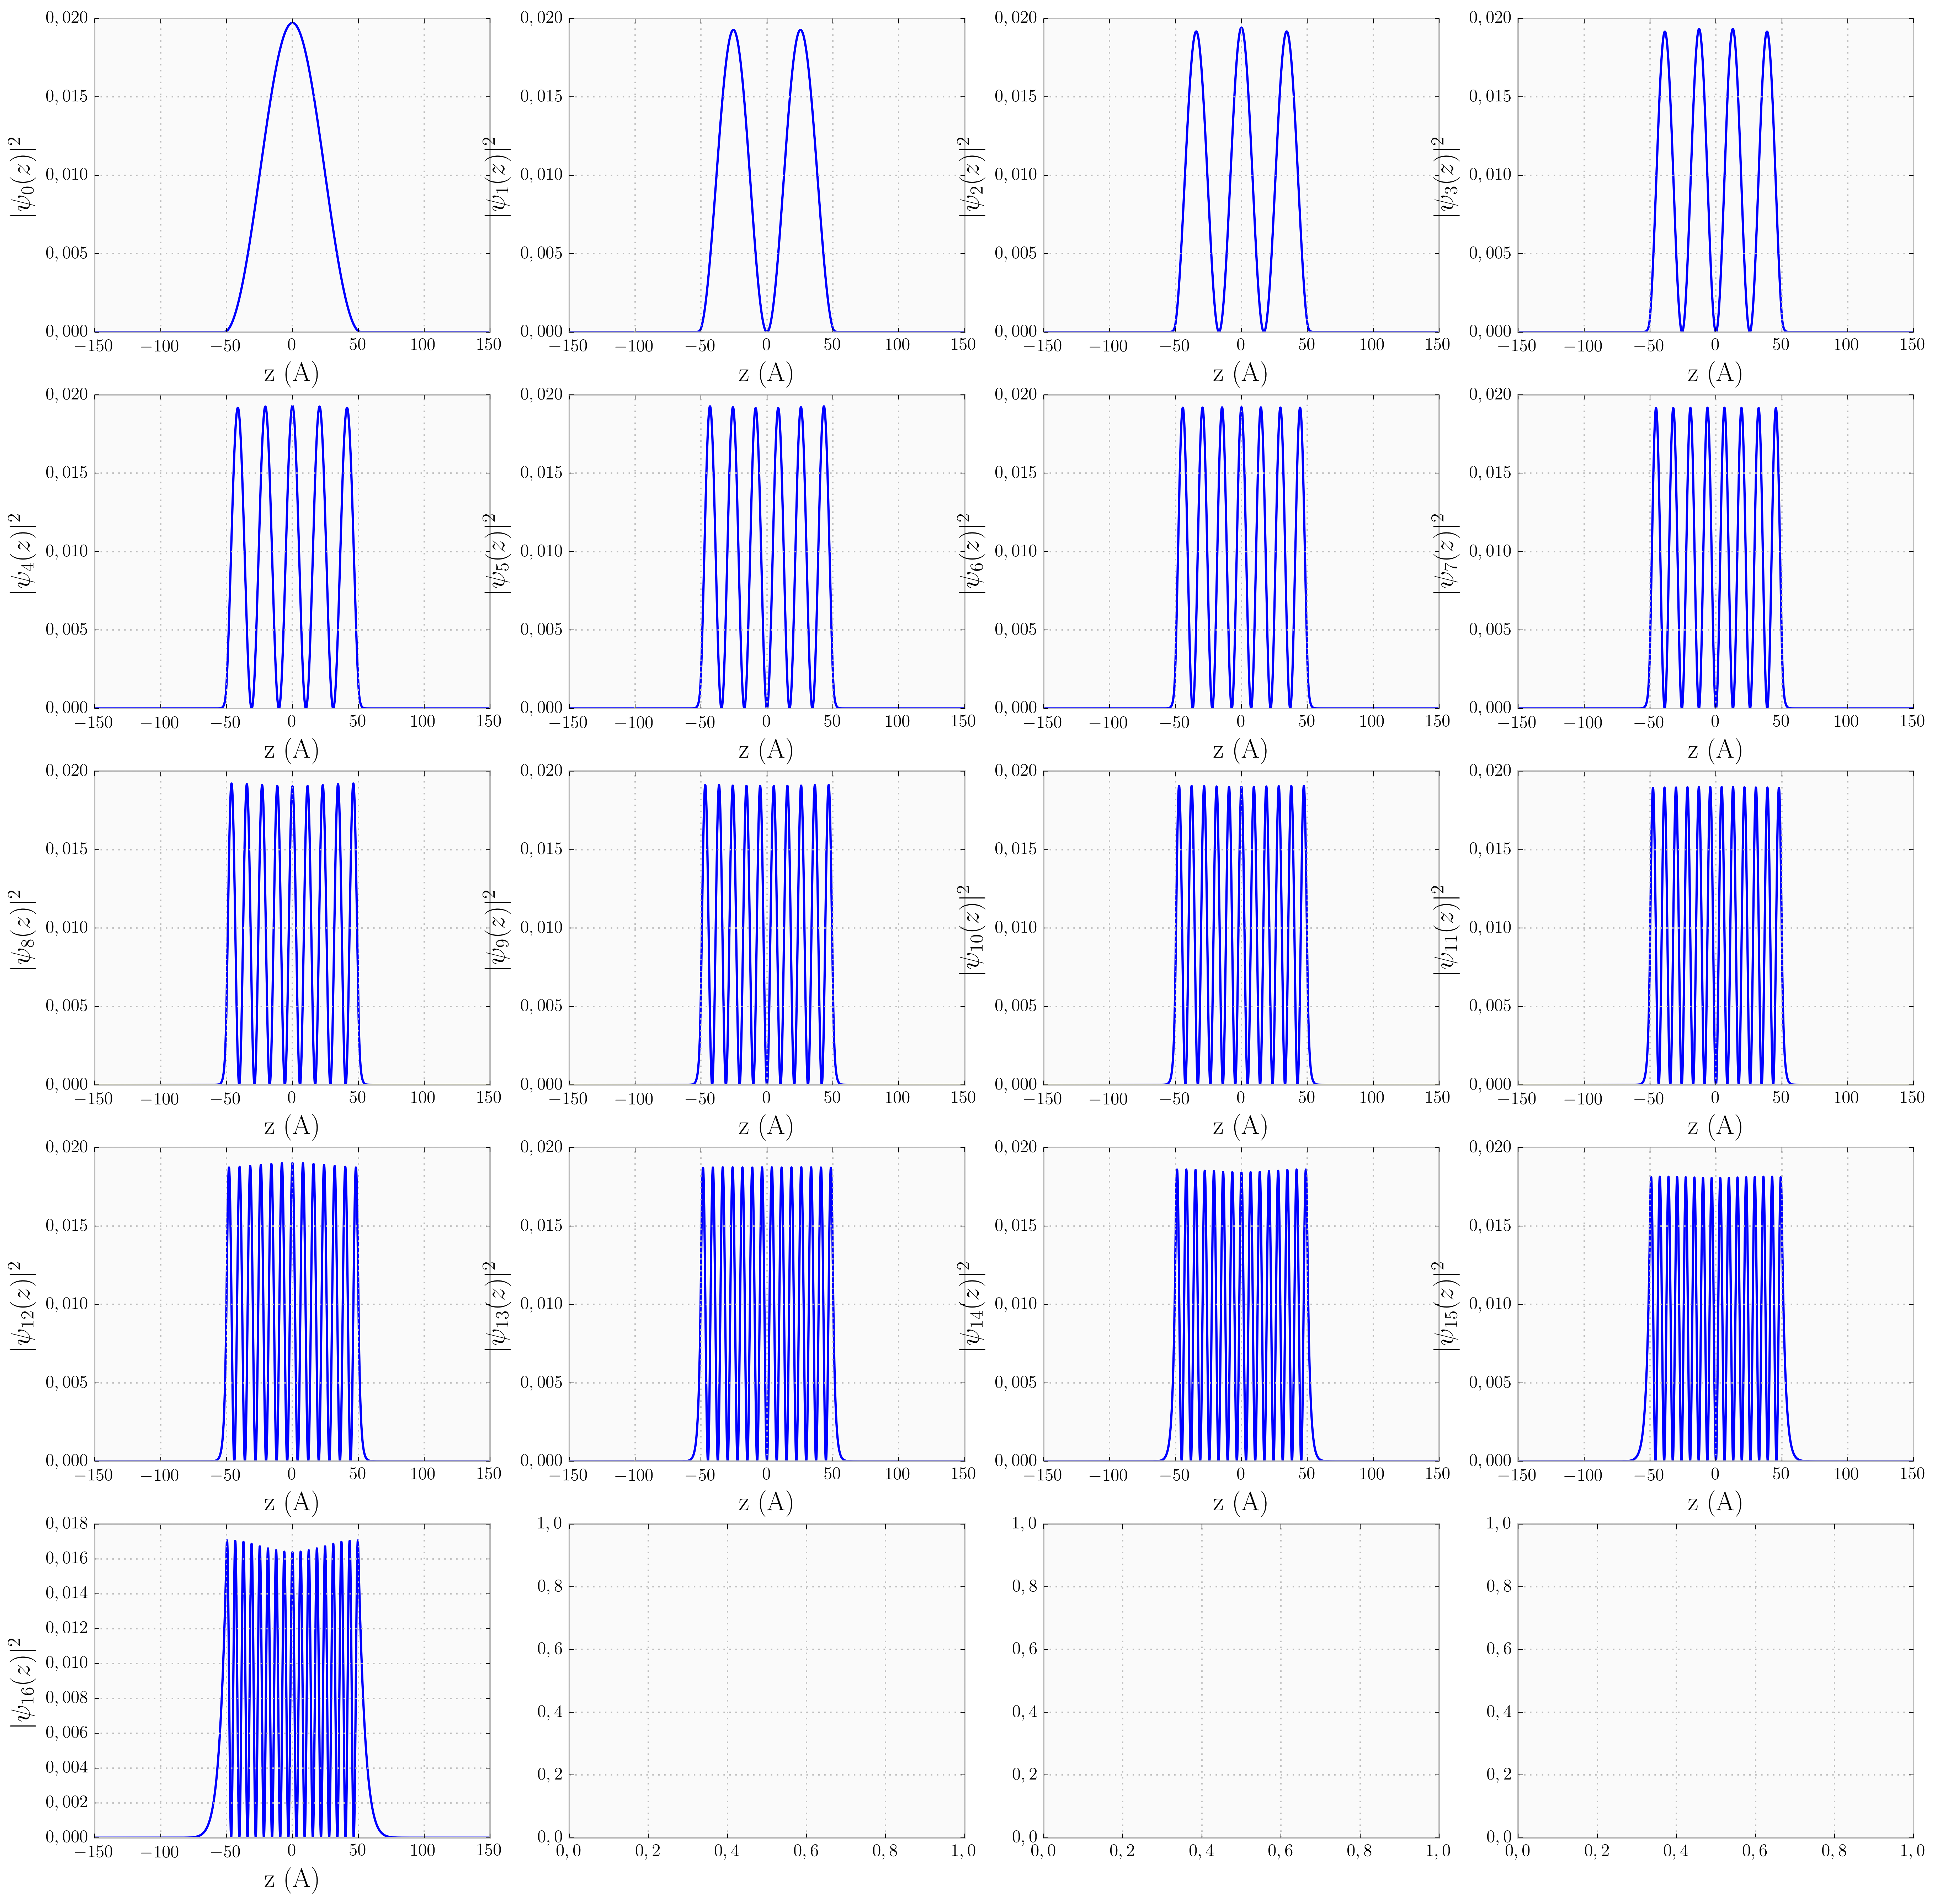

In [12]:
fix, axs = plt.subplots(5,4, figsize=(22,22))
for i in range(5):
    for j in range(4):
        if (4*i+j) >= len(poco_100.eigenstates_ang):
            continue
        axs[i,j].plot(poco_100.z_ang, np.abs(poco_100.eigenstates_ang[4*i+j])**2)
        axs[i,j].set_xlabel(r'z (A)')
        axs[i,j].set_ylabel(r'$|\psi_{%d} (z)|^2$' % (4*i+j))
plt.show()

Vamos colocar os dados em um DataFrame para depois exportá-los para um **.csv**.

In [13]:
export_values = {
    'z_ang': poco_100.z_ang, # o eixo z em Angstrom
    'v_ev': poco_100.v_ev, # o potencial em eV
}

for i, state in enumerate(poco_100.eigenstates_ang):
    export_values['psi_%02d' % i] = state # psi
    export_values['psi_squared_%d' % i] = np.abs(state)**2 # |psi|^2
results = pd.DataFrame(export_values)
results.to_csv('saidas/poco_quantico_estados.csv')
results.head()

psi_00  \
0  (-4.82294817881e-15+1.12964096718e-15j)   
1  (-1.05227960265e-14+1.03796143012e-15j)   
2    (1.22003432191e-15+9.5089444218e-16j)   
3  (-1.60701395839e-14+8.92398761367e-16j)   
4   (7.23442226821e-15+8.23075411143e-16j)   

                                    psi_01  \
0  (-3.29406817957e-12-9.23908767427e-17j)   
1   (3.29422902649e-12-9.55842216151e-17j)   
2  (-3.29416290053e-12-9.01317914318e-17j)   
3   (3.29439463925e-12-1.14971940227e-16j)   
4  (-3.29435591684e-12-9.90009876382e-17j)   

                                    psi_02  \
0    (1.89685488369e-15-1.5486171481e-15j)   
1  (-1.57371978487e-14-1.47538535868e-15j)   
2   (1.94546520686e-14-1.43497471378e-15j)   
3  (-3.33998464234e-14-1.35396626355e-15j)   
4   (3.70124492678e-14-1.31290057687e-15j)   

                                    psi_03  \
0  (-6.65684309279e-12+1.62156548197e-17j)   
1   (6.65654736869e-12-3.23319078479e-17j)   
2  (-6.65692299997e-12-7.55440994737e-17j)   
3   (6.65693848969e-12-9.10137357047e-17j)   
4  (-6.65729237544e-12-8.88866409581e-17j)   

                                    psi_04  \
0   (2.58336684144e-15+1.71939908397e-15j)   
1  (-2.68441416418e-14+1.59549638385e-15j)   
2   (3.23635863828e-14+1.50051379996e-15j)   
3    (-5.618585553e-14+1.38946754031e-15j)   
4   (6.21056750103e-14+1.30348842182e-15j)   

                                    psi_05  \
0  (-1.00738141044e-11-1.08157349786e-15j)   
1   (1.00753716049e-11-1.05032590027e-15j)   
2   (-1.00741501524e-11-9.7983700616e-16j)   
3   (1.00758083477e-11-9.39206819295e-16j)   
4  (-1.00748359522e-11-8.57115115791e-16j)   

                                    psi_06  \
0    (9.0381653665e-15-1.55288386129e-15j)   
1  (-3.25773971547e-14-1.47869246396e-15j)   
2   (5.03772429289e-14-1.36916856347e-15j)   
3   (-7.4288299234e-14-1.32647489479e-15j)   
4   (9.17544563236e-14-1.21613583764e-15j)   

                                    psi_07  \
0  (-1.34261504582e-11+4.84283761882e-16j)   
1   (1.34272094008e-11+4.88771433964e-16j)   
2  (-1.34267076408e-11+4.52422542553e-16j)   
3   (1.34277016281e-11+4.30129757794e-16j)   
4  (-1.34277087815e-11+3.82003362191e-16j)   

                                    psi_08  \
0   (1.25868856246e-14+7.83583350216e-16j)   
1  (-4.09073678505e-14+7.12970155475e-16j)   
2   (6.63290640326e-14+6.35701013715e-16j)   
3  (-9.43444077801e-14+6.02188072166e-16j)   
4   (1.20033100157e-13+5.38664544098e-16j)   

                                    psi_09     ...      psi_squared_2  \
0  (-1.67870529003e-11+2.10897374484e-16j)     ...       5.996274e-30   
1   (1.67897970222e-11+3.05038815012e-16j)     ...       2.498362e-28   
2  (-1.67875923063e-11+3.61441494123e-16j)     ...       3.805426e-28   
3   (1.67905319264e-11+3.77626964146e-16j)     ...       1.117383e-27   
4  (-1.67887176089e-11+3.68970096635e-16j)     ...       1.371645e-27   

   psi_squared_3  psi_squared_4  psi_squared_5  psi_squared_6  psi_squared_7  \
0   4.431356e-23   9.630117e-30   1.014817e-22   8.409988e-29   1.802615e-22   
1   4.430962e-23   7.231535e-28   1.015131e-22   1.063473e-27   1.802900e-22   
2   4.431462e-23   1.049653e-27   1.014885e-22   2.539741e-27   1.802765e-22   
3   4.431483e-23   3.158781e-27   1.015219e-22   5.520511e-27   1.803032e-22   
4   4.431954e-23   3.858814e-27   1.015023e-22   8.420359e-27   1.803034e-22   

   psi_squared_8  psi_squared_9  v_ev       z_ang  
0   1.590437e-28   2.818051e-22   1.0 -150.000000  
1   1.673921e-27   2.818973e-22   1.0 -149.853444  
2   4.399949e-27   2.818233e-22   1.0 -149.706888  
3   8.901230e-27   2.819220e-22   1.0 -149.560332  
4   1.440824e-26   2.818610e-22   1.0 -149.413776  

[5 rows x 36 columns]

Nós temos também informações sobre tempo de processamento e número de iterações para cada nível de energia:

In [14]:
perf_metrics = pd.DataFrame({
    'time (s)': poco_100.timers,
    'iterations': poco_100.counters,
    'numeric precision (%)': 100*poco_100.eigenvalues_precisions,
    'analytic (eV)': poco_100.analytical_eigenvalues,
    'numeric (eV)': poco_100.eigenvalues,
    'actual precision (%)': 100.0*(poco_100.eigenvalues/poco_100.analytical_eigenvalues-1.0)
})
perf_metrics.to_csv('saidas/poco_quantico_metricas.csv')
perf_metrics

actual precision (%)  analytic (eV)  iterations  numeric (eV)  \
0               0.200938       0.003483      104000      0.003490   
1               0.158408       0.013930       76000      0.013952   
2               0.122632       0.031335       48000      0.031373   
3               0.110834       0.055689       41000      0.055751   
4               0.099745       0.086978       31000      0.087064   
5               0.086344       0.125181       29000      0.125290   
6               0.087840       0.170275       23000      0.170425   
7               0.083290       0.222225       22000      0.222410   
8               0.075690       0.280986       19000      0.281199   
9               0.074668       0.346501       18000      0.346759   
10              0.071161       0.418689       16000      0.418987   
11              0.069128       0.497441       15000      0.497785   
12              0.068879       0.582592       13000      0.582993   
13              0.060598       0.673884       13000      0.674293   
14              0.053951       0.770857       12000      0.771273   
15              0.052796       0.872494       12000      0.872955   
16              0.076349       0.974871       15000      0.975615   

    numeric precision (%)    time (s)  
0                0.009897   79.097671  
1                0.009482  117.730071  
2                0.008770  108.682453  
3                0.009870  115.231905  
4                0.009191  108.636536  
5                0.007457  120.827942  
6                0.009140  112.861944  
7                0.007595  119.852372  
8                0.006839  120.395632  
9                0.006870  121.071307  
10               0.006269   96.079016  
11               0.007496   87.088524  
12               0.009941  114.925910  
13               0.007896  123.765117  
14               0.008039  122.778017  
15               0.008532  118.763190  
16               0.008492  160.496706

## Augumas relações interessantes

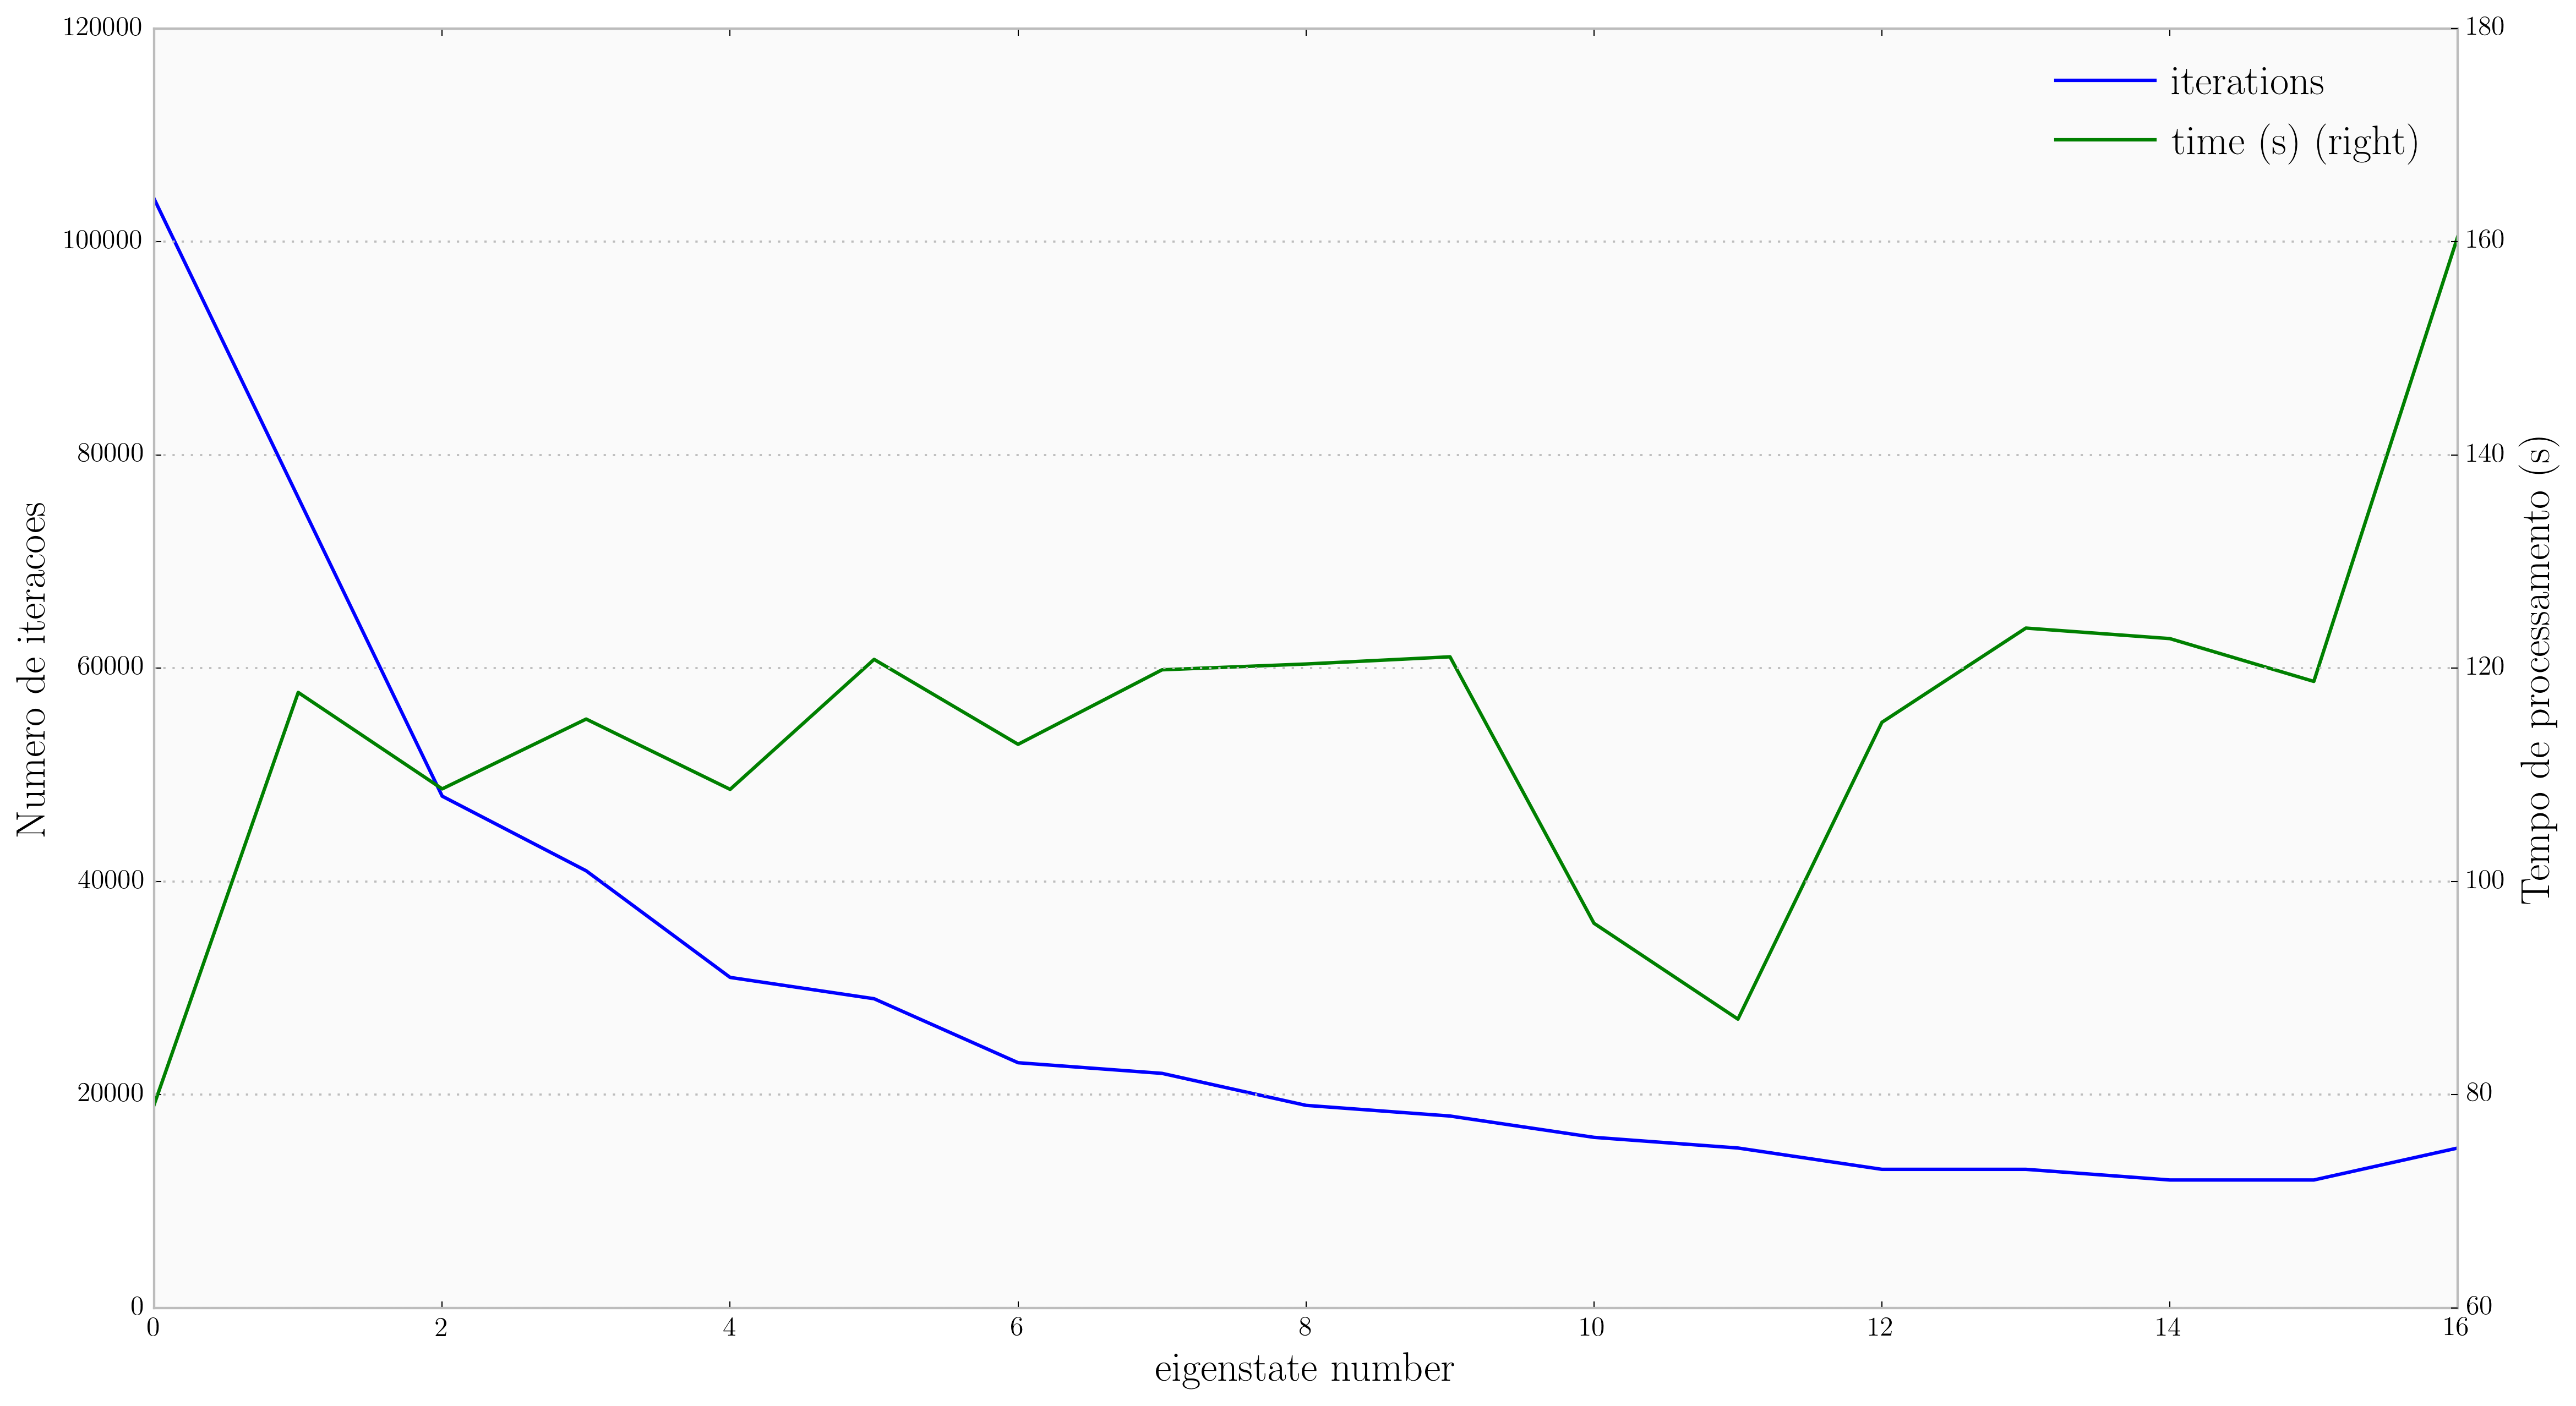

In [15]:
metrics = perf_metrics.copy()
metrics.reset_index(inplace=True)
ax = metrics[['iterations', 'time (s)']].plot(secondary_y='time (s)', figsize=(18,10))
ax.set_xlabel('eigenstate number')
ax.set_ylabel('Numero de iteracoes')
ax.right_ax.set_ylabel('Tempo de processamento (s)')
plt.show()

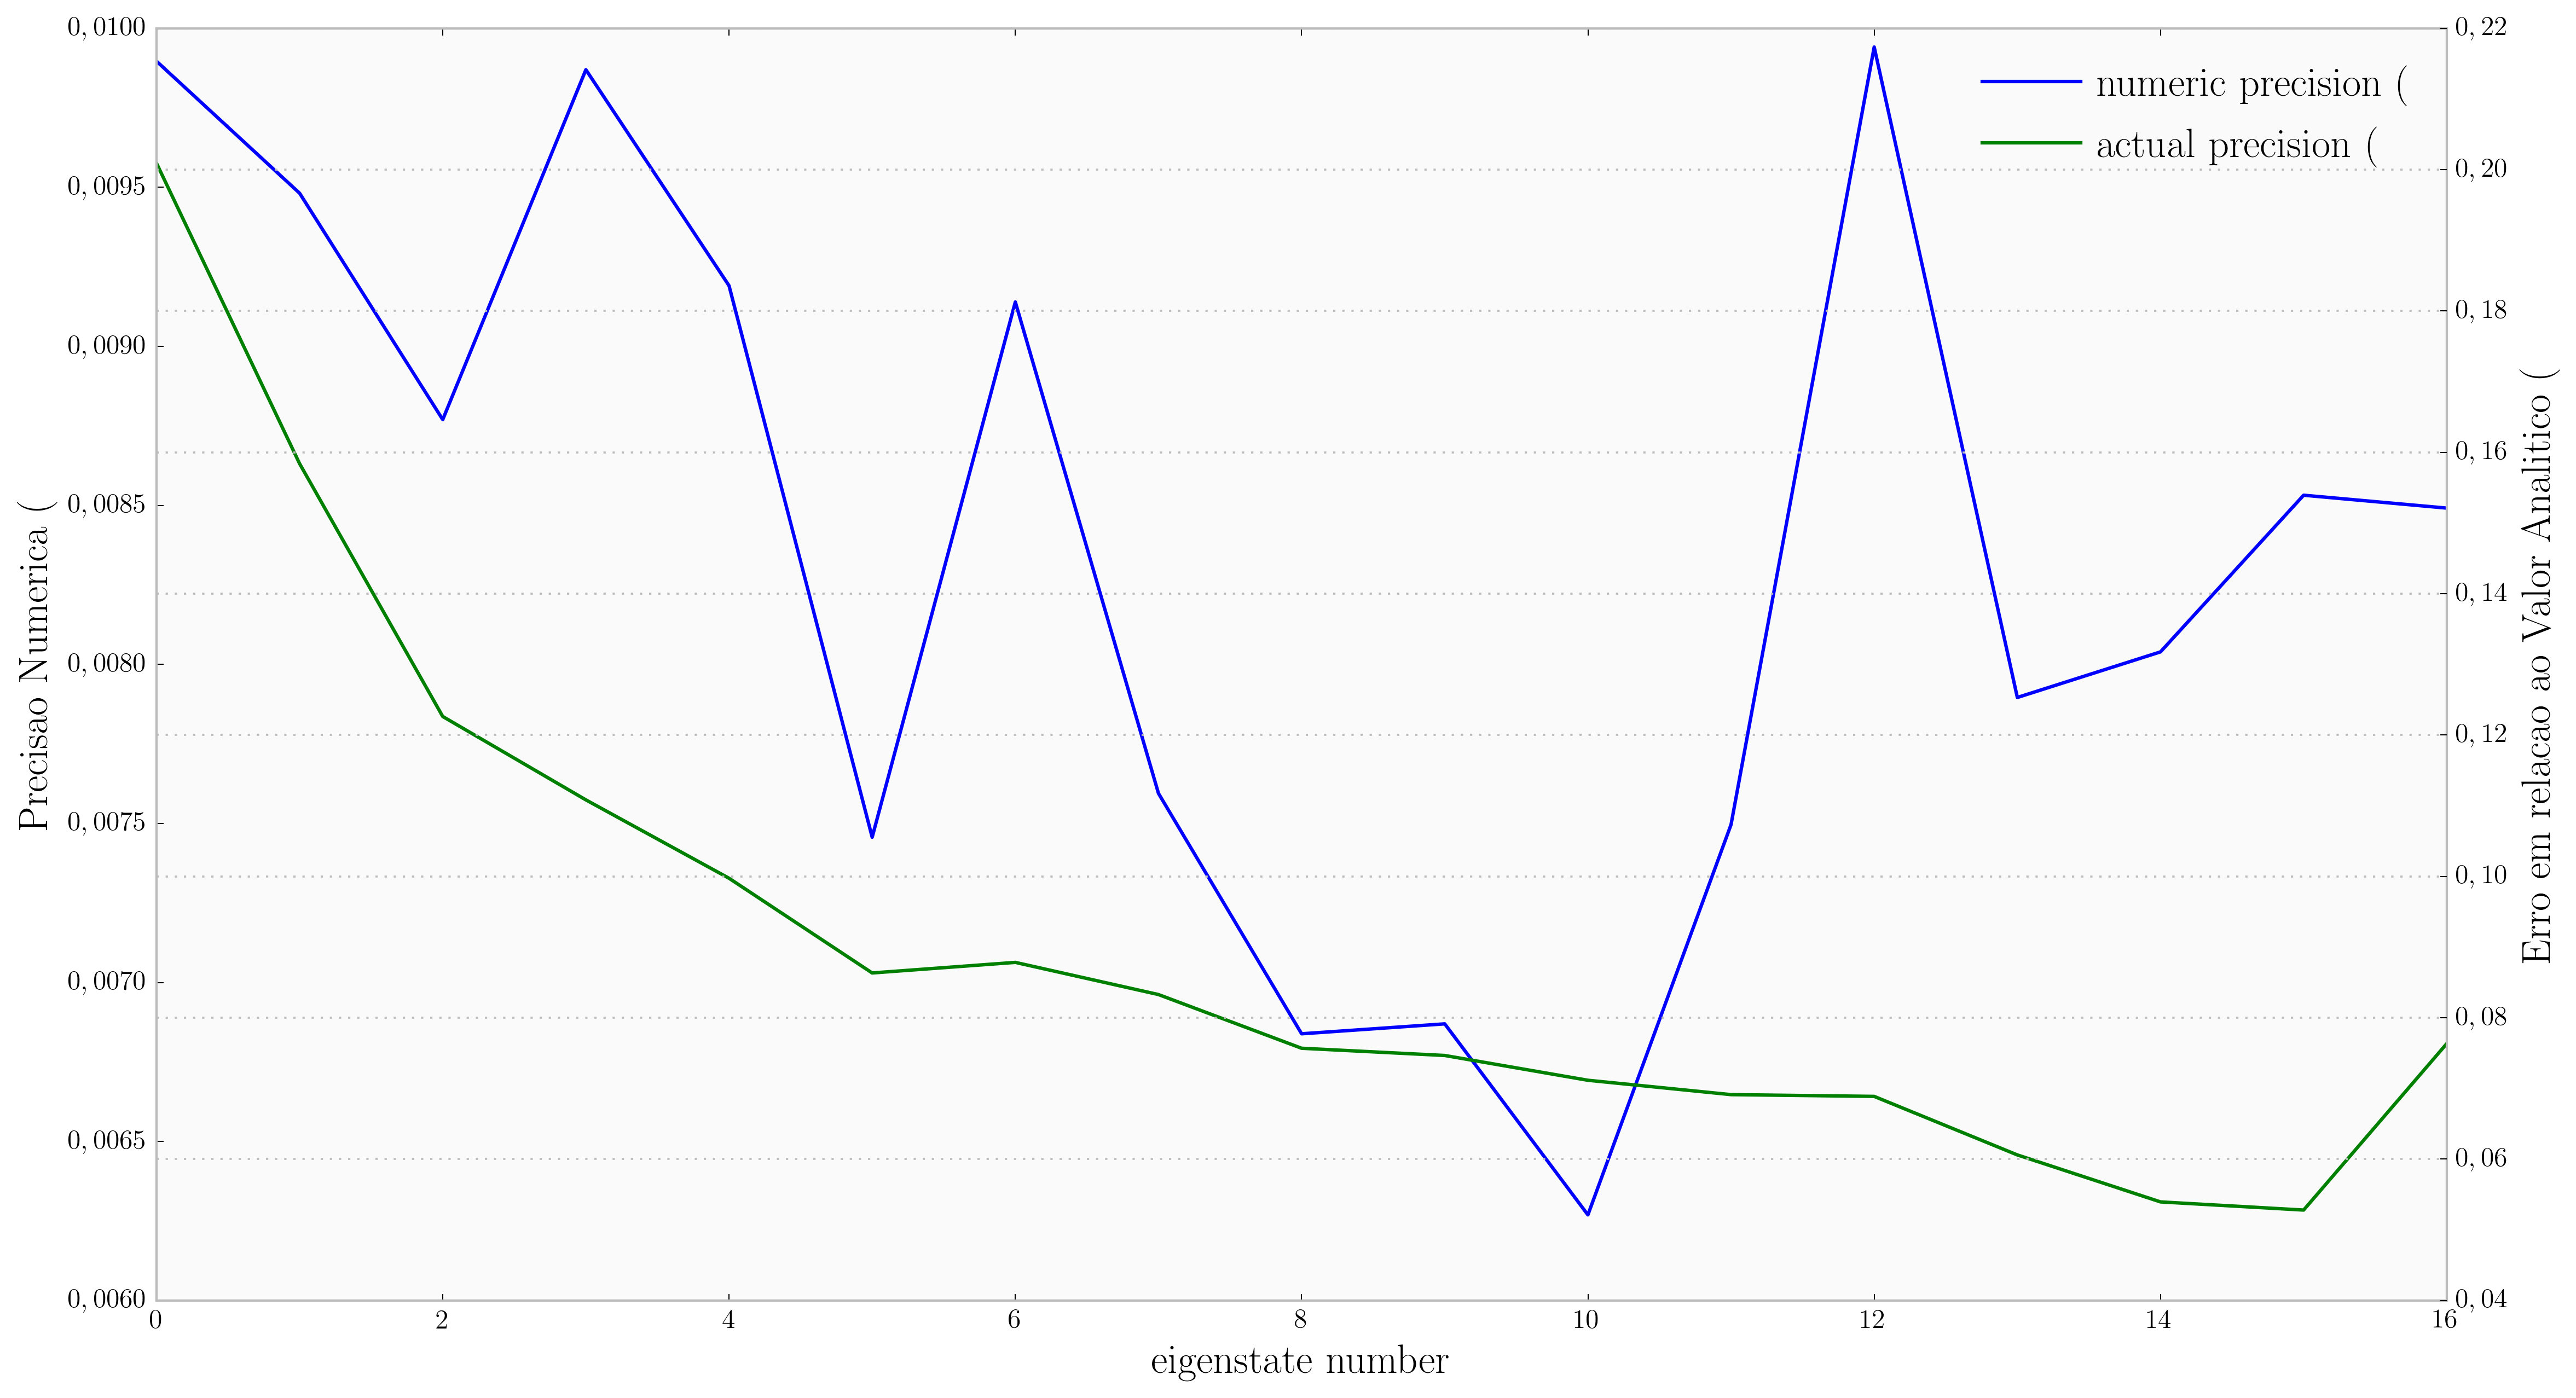

In [16]:
ax = metrics[['numeric precision (%)', 'actual precision (%)']].plot(secondary_y='actual precision (%)', figsize=(18,10))
ax.set_xlabel('eigenstate number')
ax.set_ylabel('Precisao Numerica (%)')
ax.right_ax.set_ylabel('Erro em relacao ao Valor Analitico (%)')
plt.show()

## Verificando os resultados analíticos

Aqui vamos variar o dispositivo em largura e verificar os autovalores obtidos analiticamente.

In [17]:
eigenvalues = []
eigenvalues_per_length = []
for Vb in [1.0]:
    for L in np.linspace(10, 80, 100):
        d = PocoQuantico(well_length=L, well_height=Vb)
        evs = d.solucao_analitica()
        for ev in evs:
            eigenvalues.append((L,ev))
        eigenvalues_per_length.append((L, len(evs)))
        print("finalizamos %.2f" % L)

finalizamos 10.00
finalizamos 10.71
finalizamos 11.41
finalizamos 12.12
finalizamos 12.83
finalizamos 13.54
finalizamos 14.24
finalizamos 14.95
finalizamos 15.66
finalizamos 16.36
finalizamos 17.07
finalizamos 17.78
finalizamos 18.48
finalizamos 19.19
finalizamos 19.90
finalizamos 20.61
finalizamos 21.31
finalizamos 22.02
finalizamos 22.73
finalizamos 23.43
finalizamos 24.14
finalizamos 24.85
finalizamos 25.56
finalizamos 26.26
finalizamos 26.97
finalizamos 27.68
finalizamos 28.38
finalizamos 29.09
finalizamos 29.80
finalizamos 30.51
finalizamos 31.21
finalizamos 31.92
finalizamos 32.63
finalizamos 33.33
finalizamos 34.04
finalizamos 34.75
finalizamos 35.45
finalizamos 36.16
finalizamos 36.87
finalizamos 37.58
finalizamos 38.28
finalizamos 38.99
finalizamos 39.70
finalizamos 40.40
finalizamos 41.11
finalizamos 41.82
finalizamos 42.53
finalizamos 43.23
finalizamos 43.94
finalizamos 44.65
finalizamos 45.35
finalizamos 46.06
finalizamos 46.77
finalizamos 47.47
finalizamos 48.18
finalizamo

In [18]:
fix, ax = plt.subplots(1,1, figsize=(18,14))
x,y=tuple(zip(*eigenvalues))
ax.scatter(x,y, marker='.')
plt.show()

In [19]:
fix, ax = plt.subplots(1,1, figsize=(18,10))
x,y=tuple(zip(*eigenvalues_per_length))
ax.scatter(x,y)
plt.show()

vamos exportar os valores

In [20]:
L,e=tuple(zip(*eigenvalues))
l_e = pd.DataFrame({'L':L, 'e':e})
l_e.to_csv('saidas/poco_quantico_autovalores_por_comprimento.csv')
#l_e

In [21]:
L,n=tuple(zip(*eigenvalues_per_length))
l_n = pd.DataFrame({'L':L, 'n':n})
l_n.to_csv('saidas/poco_quantico_numero_de_autovalores_por_comprimento.csv')
#l_n

In [22]:
eigenvalues = []
eigenvalues_per_length = []
for Vb in [1.0]:
    for L in np.linspace(10, 80, 100):
        d = PocoQuantico(well_length=L, well_height=Vb, N=2048, dt=1e-18)
        d.evolucao_imaginaria(precision=1e-4)
        evs = d.eigenvalues
        for ev in evs:
            eigenvalues.append((L,ev))
        eigenvalues_per_length.append((L, len(evs)))
        print('Estamos em L = %.2f' % L)
        
L,e=tuple(zip(*eigenvalues))
l_e = pd.DataFrame({'L':L, 'e':e})
l_e.to_csv('saidas/poco_quantico_autovalores_numericos_por_comprimento.csv')

Energy [0]:
                                Numeric=1.9087770884e-01
                                Analytic=1.9076054414e-01
                                iterations=5000
Energy [1]:
                                Numeric=7.0451637873e-01
                                Analytic=7.0276957111e-01
                                iterations=5000
Estamos em L = 10.00
Energy [0]:
                                Numeric=1.7334442584e-01
                                Analytic=1.7322678903e-01
                                iterations=5000
Energy [1]:
                                Numeric=6.4824094252e-01
                                Analytic=6.4731212760e-01
                                iterations=5000
Estamos em L = 10.71
Energy [0]:
                                Numeric=1.5807630540e-01
                                Analytic=1.5796347786e-01
                                iterations=5000
Energy [1]:
                                Numeric=5.9741061257e-01
              

Energy [1]:
                                Numeric=2.4691062584e-01
                                Analytic=2.4671268467e-01
                                iterations=7000
Energy [2]:
                                Numeric=5.4217948172e-01
                                Analytic=5.4176858088e-01
                                iterations=6000
Energy [3]:
                                Numeric=9.0677023073e-01
                                Analytic=9.0595404030e-01
                                iterations=10000
Estamos em L = 20.61
Energy [0]:
                                Numeric=5.8999372120e-02
                                Analytic=5.8949565955e-02
                                iterations=9000
Energy [1]:
                                Numeric=2.3356030754e-01
                                Analytic=2.3337076703e-01
                                iterations=7000
Energy [2]:
                                Numeric=5.1415230715e-01
                                An

Energy [3]:
                                Numeric=5.8365984090e-01
                                Analytic=5.8320329872e-01
                                iterations=7000
Energy [4]:
                                Numeric=8.7807862853e-01
                                Analytic=8.7741382756e-01
                                iterations=9000
Estamos em L = 27.68
Energy [0]:
                                Numeric=3.6049031396e-02
                                Analytic=3.6017084372e-02
                                iterations=14000
Energy [1]:
                                Numeric=1.4351694771e-01
                                Analytic=1.4339242258e-01
                                iterations=10000
Energy [2]:
                                Numeric=3.2002116991e-01
                                Analytic=3.1975508218e-01
                                iterations=7000
Energy [3]:
                                Numeric=5.5987849867e-01
                                A

Energy [0]:
                                Numeric=2.6118593760e-02
                                Analytic=2.6093828026e-02
                                iterations=18000
Energy [1]:
                                Numeric=1.0417410572e-01
                                Analytic=1.0407942900e-01
                                iterations=13000
Energy [2]:
                                Numeric=2.3316341076e-01
                                Analytic=2.3296387866e-01
                                iterations=9000
Energy [3]:
                                Numeric=4.1096815544e-01
                                Analytic=4.1062972816e-01
                                iterations=8000
Energy [4]:
                                Numeric=6.3295225116e-01
                                Analytic=6.3245220289e-01
                                iterations=7000
Energy [5]:
                                Numeric=8.8522294590e-01
                                Analytic=8.8450302434e

Energy [1]:
                                Numeric=8.1618807972e-02
                                Analytic=8.1541724340e-02
                                iterations=16000
Energy [2]:
                                Numeric=1.8299051111e-01
                                Analytic=1.8283096193e-01
                                iterations=11000
Energy [3]:
                                Numeric=3.2351789784e-01
                                Analytic=3.2324906098e-01
                                iterations=10000
Energy [4]:
                                Numeric=5.0118818006e-01
                                Analytic=5.0078066477e-01
                                iterations=8000
Energy [5]:
                                Numeric=7.1154855784e-01
                                Analytic=7.1099123458e-01
                                iterations=8000
Energy [6]:
                                Numeric=9.3925793974e-01
                                Analytic=9.3847063393

Energy [5]:
                                Numeric=5.9566557600e-01
                                Analytic=5.9518098902e-01
                                iterations=8000
Energy [6]:
                                Numeric=7.9837115452e-01
                                Analytic=7.9774962537e-01
                                iterations=8000
Energy [7]:
                                Numeric=9.9863540089e-01
                                Analytic=9.9648897578e-01
                                iterations=26000
Estamos em L = 43.23
Energy [0]:
                                Numeric=1.6437520152e-02
                                Analytic=1.6420497957e-02
                                iterations=27000
Energy [1]:
                                Numeric=6.5652828861e-02
                                Analytic=6.5590884714e-02
                                iterations=20000
Energy [2]:
                                Numeric=1.4735041929e-01
                                

Energy [2]:
                                Numeric=1.2787837636e-01
                                Analytic=1.2776425225e-01
                                iterations=15000
Energy [3]:
                                Numeric=2.2665768862e-01
                                Analytic=2.2646312154e-01
                                iterations=13000
Energy [4]:
                                Numeric=3.5263009146e-01
                                Analytic=3.5233043495e-01
                                iterations=10000
Energy [5]:
                                Numeric=5.0461765865e-01
                                Analytic=5.0419742271e-01
                                iterations=9000
Energy [6]:
                                Numeric=6.8027584792e-01
                                Analytic=6.7973721984e-01
                                iterations=8000
Energy [7]:
                                Numeric=8.7336440556e-01
                                Analytic=8.7266776108

Energy [7]:
                                Numeric=7.7403857789e-01
                                Analytic=5.9874227213e-01
                                iterations=9000
Energy [8]:
                                Numeric=9.5707324477e-01
                                Analytic=7.7345405080e-01
                                iterations=13000
Energy [9]:
                                Numeric=1.0144712013e+00
                                Analytic=9.5619055627e-01
                                iterations=47000
Estamos em L = 51.01
Energy [0]:
                                Numeric=1.2164964307e-02
                                Analytic=1.2151247119e-02
                                iterations=35000
Energy [1]:
                                Numeric=4.8613622891e-02
                                Analytic=4.8562451255e-02
                                iterations=25000
Energy [2]:
                                Numeric=1.0919914568e-01
                               

Energy [8]:
                                Numeric=8.5983397394e-01
                                Analytic=8.5916578781e-01
                                iterations=9000
Estamos em L = 54.55
Energy [0]:
                                Numeric=1.0755358152e-02
                                Analytic=1.0742779590e-02
                                iterations=39000
Energy [1]:
                                Numeric=4.2986082175e-02
                                Analytic=4.2939949176e-02
                                iterations=28000
Energy [2]:
                                Numeric=9.6588093785e-02
                                Analytic=9.6493600231e-02
                                iterations=18000
Energy [3]:
                                Numeric=1.7137664463e-01
                                Analytic=1.7122423401e-01
                                iterations=16000
Energy [4]:
                                Numeric=2.6707260935e-01
                               

Energy [4]:
                                Numeric=2.4349015688e-01
                                Analytic=2.4327359511e-01
                                iterations=13000
Energy [5]:
                                Numeric=3.4955070084e-01
                                Analytic=3.4925534594e-01
                                iterations=12000
Energy [6]:
                                Numeric=4.7380330614e-01
                                Analytic=4.7341680816e-01
                                iterations=10000
Energy [7]:
                                Numeric=6.1522680711e-01
                                Analytic=6.1475352053e-01
                                iterations=10000
Energy [8]:
                                Numeric=7.7173825995e-01
                                Analytic=7.7116515567e-01
                                iterations=9000
Energy [9]:
                                Numeric=9.3665585832e-01
                                Analytic=9.358980132

Energy [0]:
                                Numeric=8.7686366284e-03
                                Analytic=8.7578823942e-03
                                iterations=47000
Energy [1]:
                                Numeric=3.5051324811e-02
                                Analytic=3.5012903696e-02
                                iterations=34000
Energy [2]:
                                Numeric=7.8784046842e-02
                                Analytic=7.8707047684e-02
                                iterations=22000
Energy [3]:
                                Numeric=1.3986382164e-01
                                Analytic=1.3973584903e-01
                                iterations=19000
Energy [4]:
                                Numeric=2.1812171373e-01
                                Analytic=2.1793410385e-01
                                iterations=15000
Energy [5]:
                                Numeric=3.1332055574e-01
                                Analytic=3.13048816

Energy [2]:
                                Numeric=7.2416844106e-02
                                Analytic=7.2342200982e-02
                                iterations=23000
Energy [3]:
                                Numeric=1.2857812240e-01
                                Analytic=1.2845751659e-01
                                iterations=20000
Energy [4]:
                                Numeric=2.0056361198e-01
                                Analytic=2.0039292547e-01
                                iterations=16000
Energy [5]:
                                Numeric=2.8819822814e-01
                                Analytic=2.8795116936e-01
                                iterations=14000
Energy [6]:
                                Numeric=3.9115607847e-01
                                Analytic=3.9083253978e-01
                                iterations=12000
Energy [7]:
                                Numeric=5.0896537278e-01
                                Analytic=5.08560717

Energy [5]:
                                Numeric=2.6596470009e-01
                                Analytic=2.6573172052e-01
                                iterations=15000
Energy [6]:
                                Numeric=3.6111394006e-01
                                Analytic=3.6081788226e-01
                                iterations=13000
Energy [7]:
                                Numeric=4.7014849810e-01
                                Analytic=4.6977917737e-01
                                iterations=12000
Energy [8]:
                                Numeric=5.9249785884e-01
                                Analytic=5.9202563673e-01
                                iterations=10000
Energy [9]:
                                Numeric=7.2698682385e-01
                                Analytic=7.2644741288e-01
                                iterations=10000
Energy [10]:
                                Numeric=8.7093066216e-01
                                Analytic=8.7032139

Energy [5]:
                                Numeric=2.4618481504e-01
                                Analytic=2.4597134236e-01
                                iterations=16000
Energy [6]:
                                Numeric=3.3438317896e-01
                                Analytic=3.3409459194e-01
                                iterations=13000
Energy [7]:
                                Numeric=4.3552507419e-01
                                Analytic=4.3518662193e-01
                                iterations=13000
Energy [8]:
                                Numeric=5.4922848540e-01
                                Analytic=5.4881439193e-01
                                iterations=11000
Energy [9]:
                                Numeric=6.7471324586e-01
                                Analytic=6.7421920309e-01
                                iterations=11000
Energy [10]:
                                Numeric=8.1036440382e-01
                                Analytic=8.0979789

Energy [3]:
                                Numeric=1.0182900450e-01
                                Analytic=1.0173285095e-01
                                iterations=25000
Energy [4]:
                                Numeric=1.5892765765e-01
                                Analytic=1.5878385783e-01
                                iterations=19000
Energy [5]:
                                Numeric=2.2852626067e-01
                                Analytic=2.2832337773e-01
                                iterations=17000
Energy [6]:
                                Numeric=3.1047082505e-01
                                Analytic=3.1020633860e-01
                                iterations=14000
Energy [7]:
                                Numeric=4.0455069941e-01
                                Analytic=4.0422008005e-01
                                iterations=13000
Energy [8]:
                                Numeric=5.1042038296e-01
                                Analytic=5.10038748

Energy [12]:
                                Numeric=9.7798345432e-01
                                Analytic=9.7695082777e-01
                                iterations=15000
Estamos em L = 75.05
Energy [0]:
                                Numeric=5.9340437582e-03
                                Analytic=5.9249480708e-03
                                iterations=65000
Energy [1]:
                                Numeric=2.3721967793e-02
                                Analytic=2.3692822380e-02
                                iterations=48000
Energy [2]:
                                Numeric=5.3340406589e-02
                                Analytic=5.3282173008e-02
                                iterations=30000
Energy [3]:
                                Numeric=9.4749661763e-02
                                Analytic=9.4655340585e-02
                                iterations=26000
Energy [4]:
                                Numeric=1.4788835043e-01
                             

Energy [7]:
                                Numeric=3.5764386519e-01
                                Analytic=3.5736052474e-01
                                iterations=15000
Energy [8]:
                                Numeric=4.5157548918e-01
                                Analytic=4.5122624886e-01
                                iterations=13000
Energy [9]:
                                Numeric=5.5580933453e-01
                                Analytic=5.5538614511e-01
                                iterations=12000
Energy [10]:
                                Numeric=6.6977599047e-01
                                Analytic=6.6929784859e-01
                                iterations=11000
Energy [11]:
                                Numeric=7.9240662346e-01
                                Analytic=7.9188547664e-01
                                iterations=11000
Energy [12]:
                                Numeric=9.2078679737e-01
                                Analytic=9.20131

In [23]:
L,e=tuple(zip(*eigenvalues))
l_e = pd.DataFrame({'L':L, 'e':e})
l_e.to_csv('saidas/poco_quantico_autovalores_numericos_por_comprimento.csv')

In [24]:
numeric = pd.read_csv('saidas/poco_quantico_autovalores_numericos_por_comprimento.csv', index_col=0)

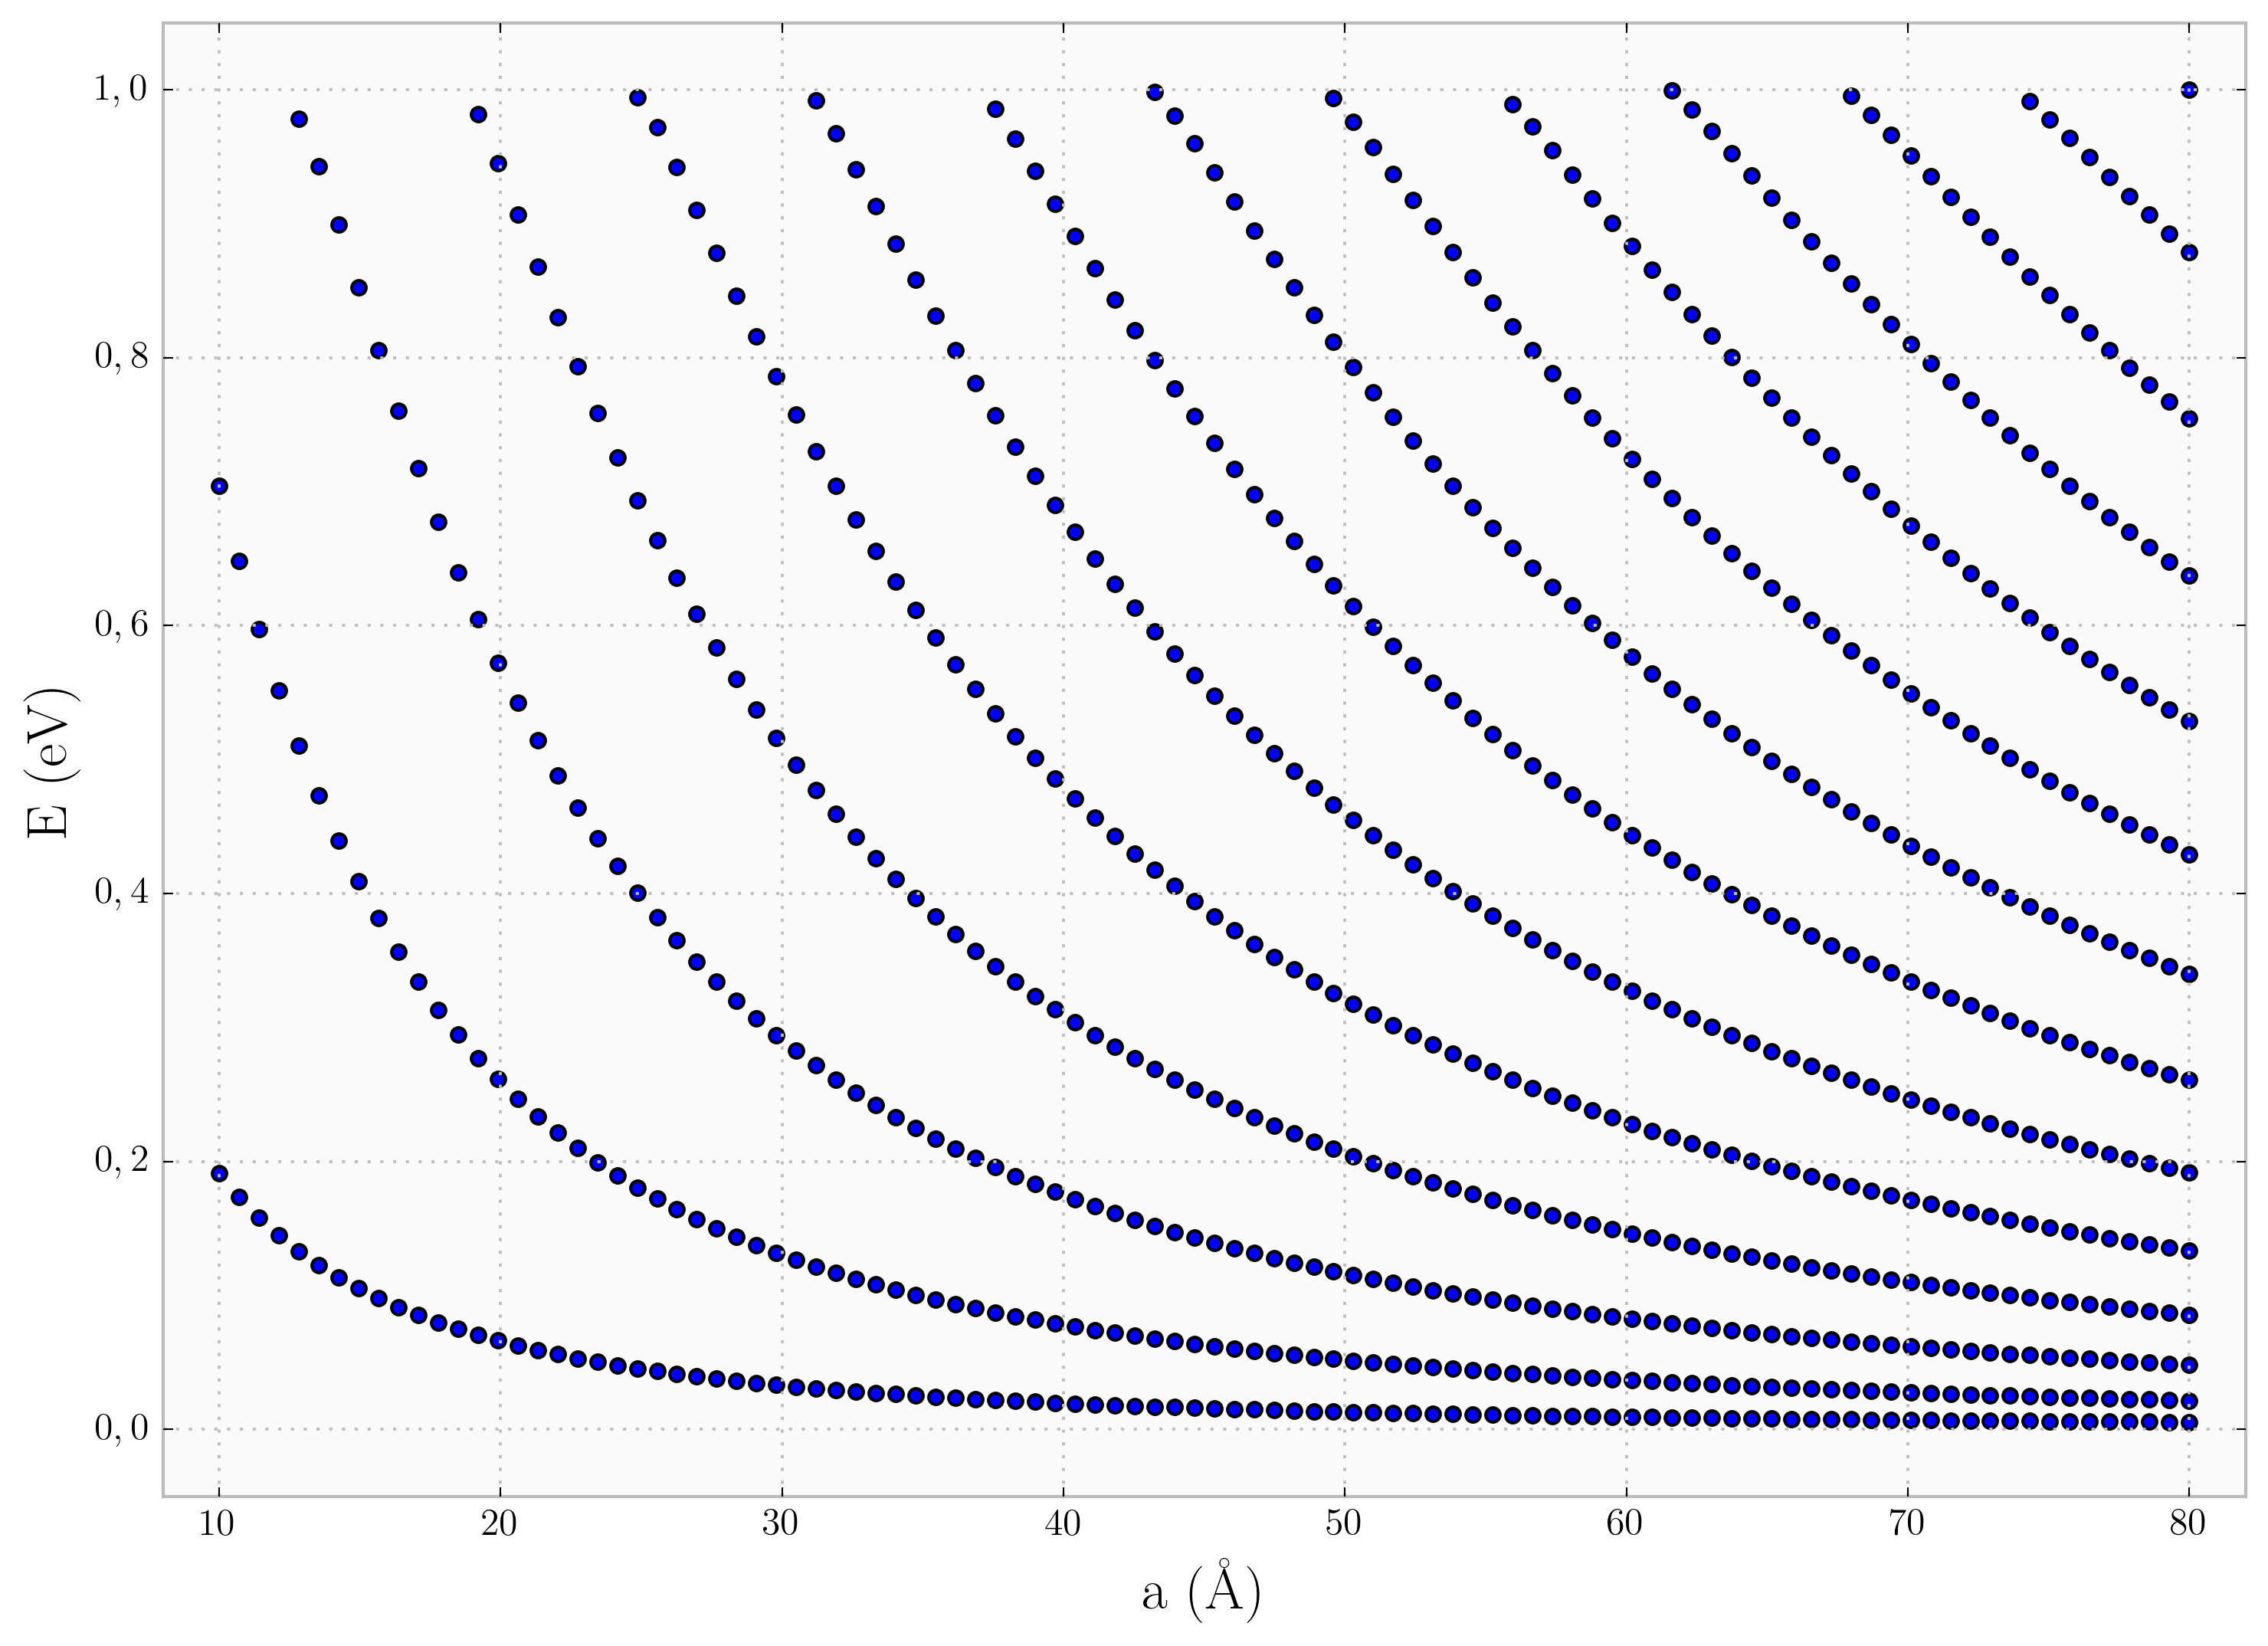

In [68]:
ax = numeric[(numeric['L'] <= 80) & (numeric['e'] <= 1.0)].plot.scatter(x='L',y='e')
ax.set_xlabel(r'a (\AA)')
ax.set_ylabel(r'E (eV)')
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([8, 82])
plt.savefig('figuras/poco_quantico_numerico.png', bbox_inches='tight')

In [67]:
analitic = pd.read_csv('saidas/poco_quantico_autovalores_por_comprimento.csv', index_col=0)
ax = analitic[analitic['L'] <= 80].plot.scatter(x='L',y='e')
ax.set_xlabel(r'a (\AA)')
ax.set_ylabel(r'E (eV)')
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([8, 82])
plt.savefig('figuras/poco_quantico_analitico.png', bbox_inches='tight')

In [27]:
numcut = pd.read_csv('saidas/poco_quantico_autovalores_numericos_por_comprimento.csv', index_col=0)
numcut = numcut[(numcut['L'] <= 80) & (numcut['e'] <= 1.0)]
anacut = pd.read_csv('saidas/poco_quantico_autovalores_por_comprimento.csv', index_col=0)
anacut = anacut[(anacut['L'] <= 80) & (anacut['e'] <= 1.0)]

In [28]:
numcut['type'] = ['num']*numcut.shape[0]
anacut['type'] = ['ana']*anacut.shape[0]

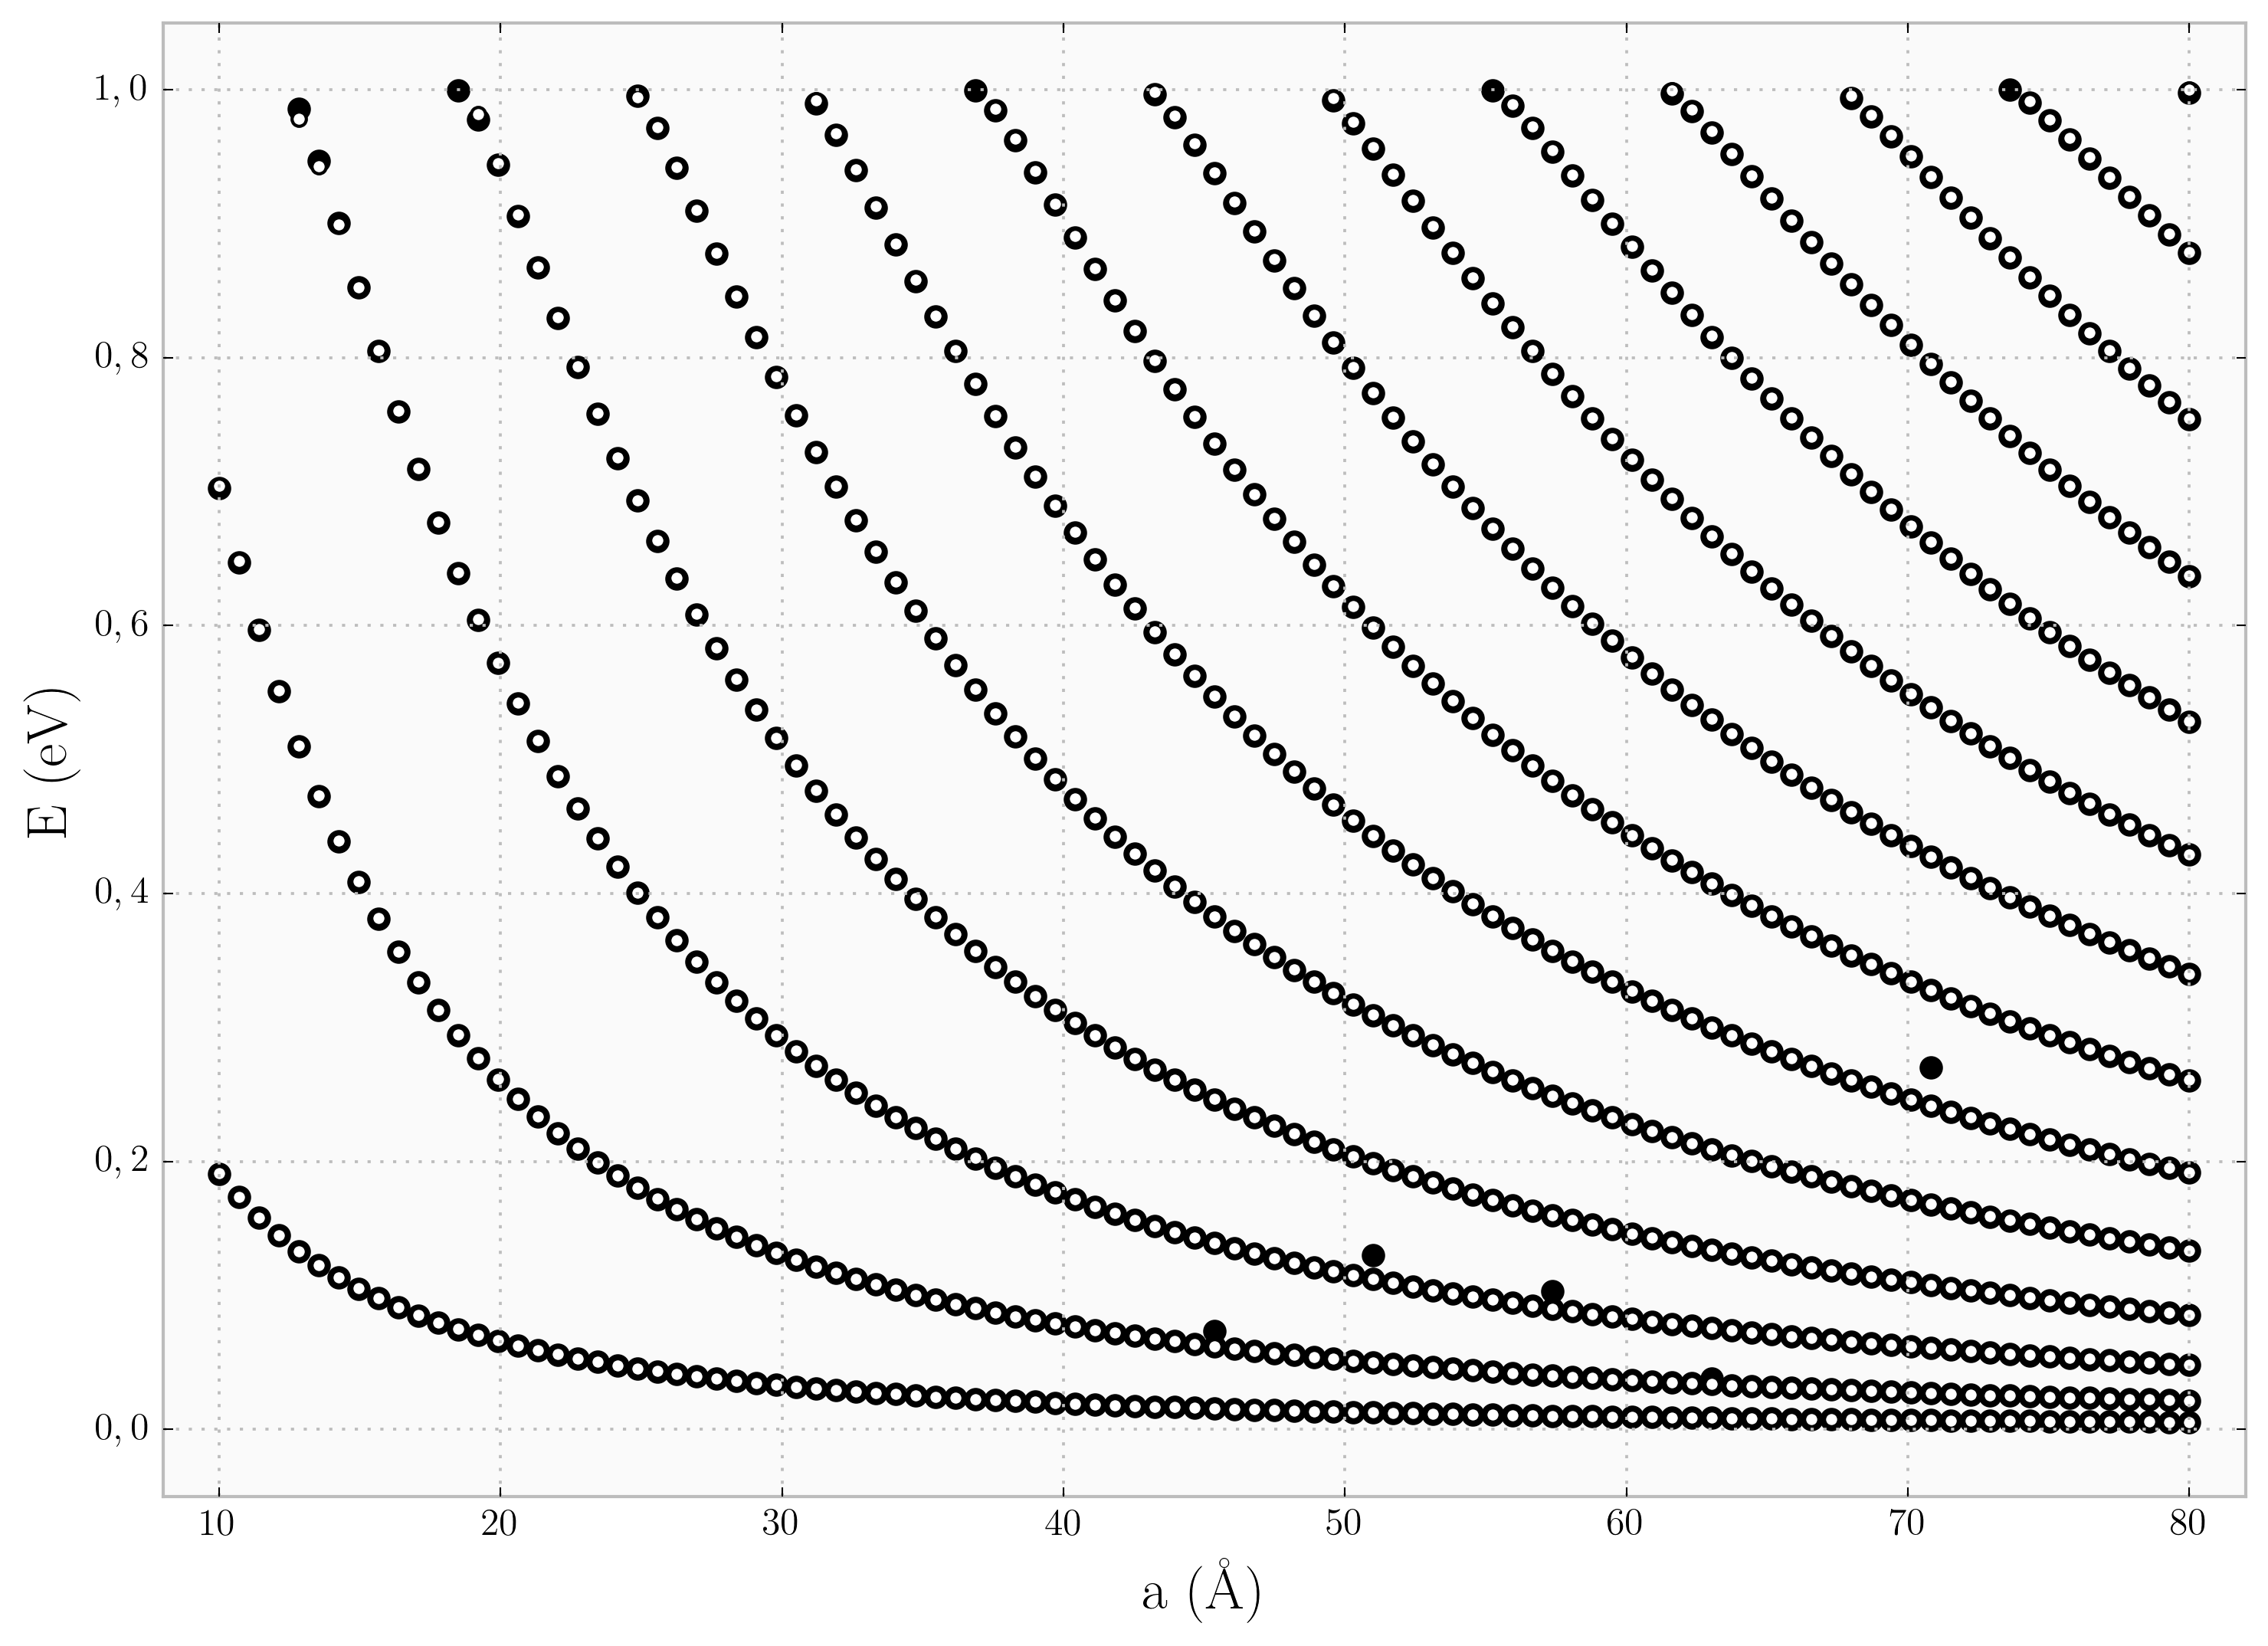

In [66]:
fig, ax = plt.subplots(1,1)
ax.scatter(anacut['L'], anacut['e'], marker='o',c='k', s=40)
ax.scatter(numcut['L'], numcut['e'], marker='o',c='w', s=20)
ax.set_xlabel(r'a (\AA)')
ax.set_ylabel(r'E (eV)')
ax.set_ylim([-0.05, 1.05])
ax.set_xlim([8, 82])
plt.savefig('figuras/poco_quantico_numerico_e_analitico.png', bbox_inches='tight')

## Poço de 50 A

In [36]:
poco_50 = PocoQuantico(well_length=50.0, well_height=1.0, N=2048, dt=1e-18)

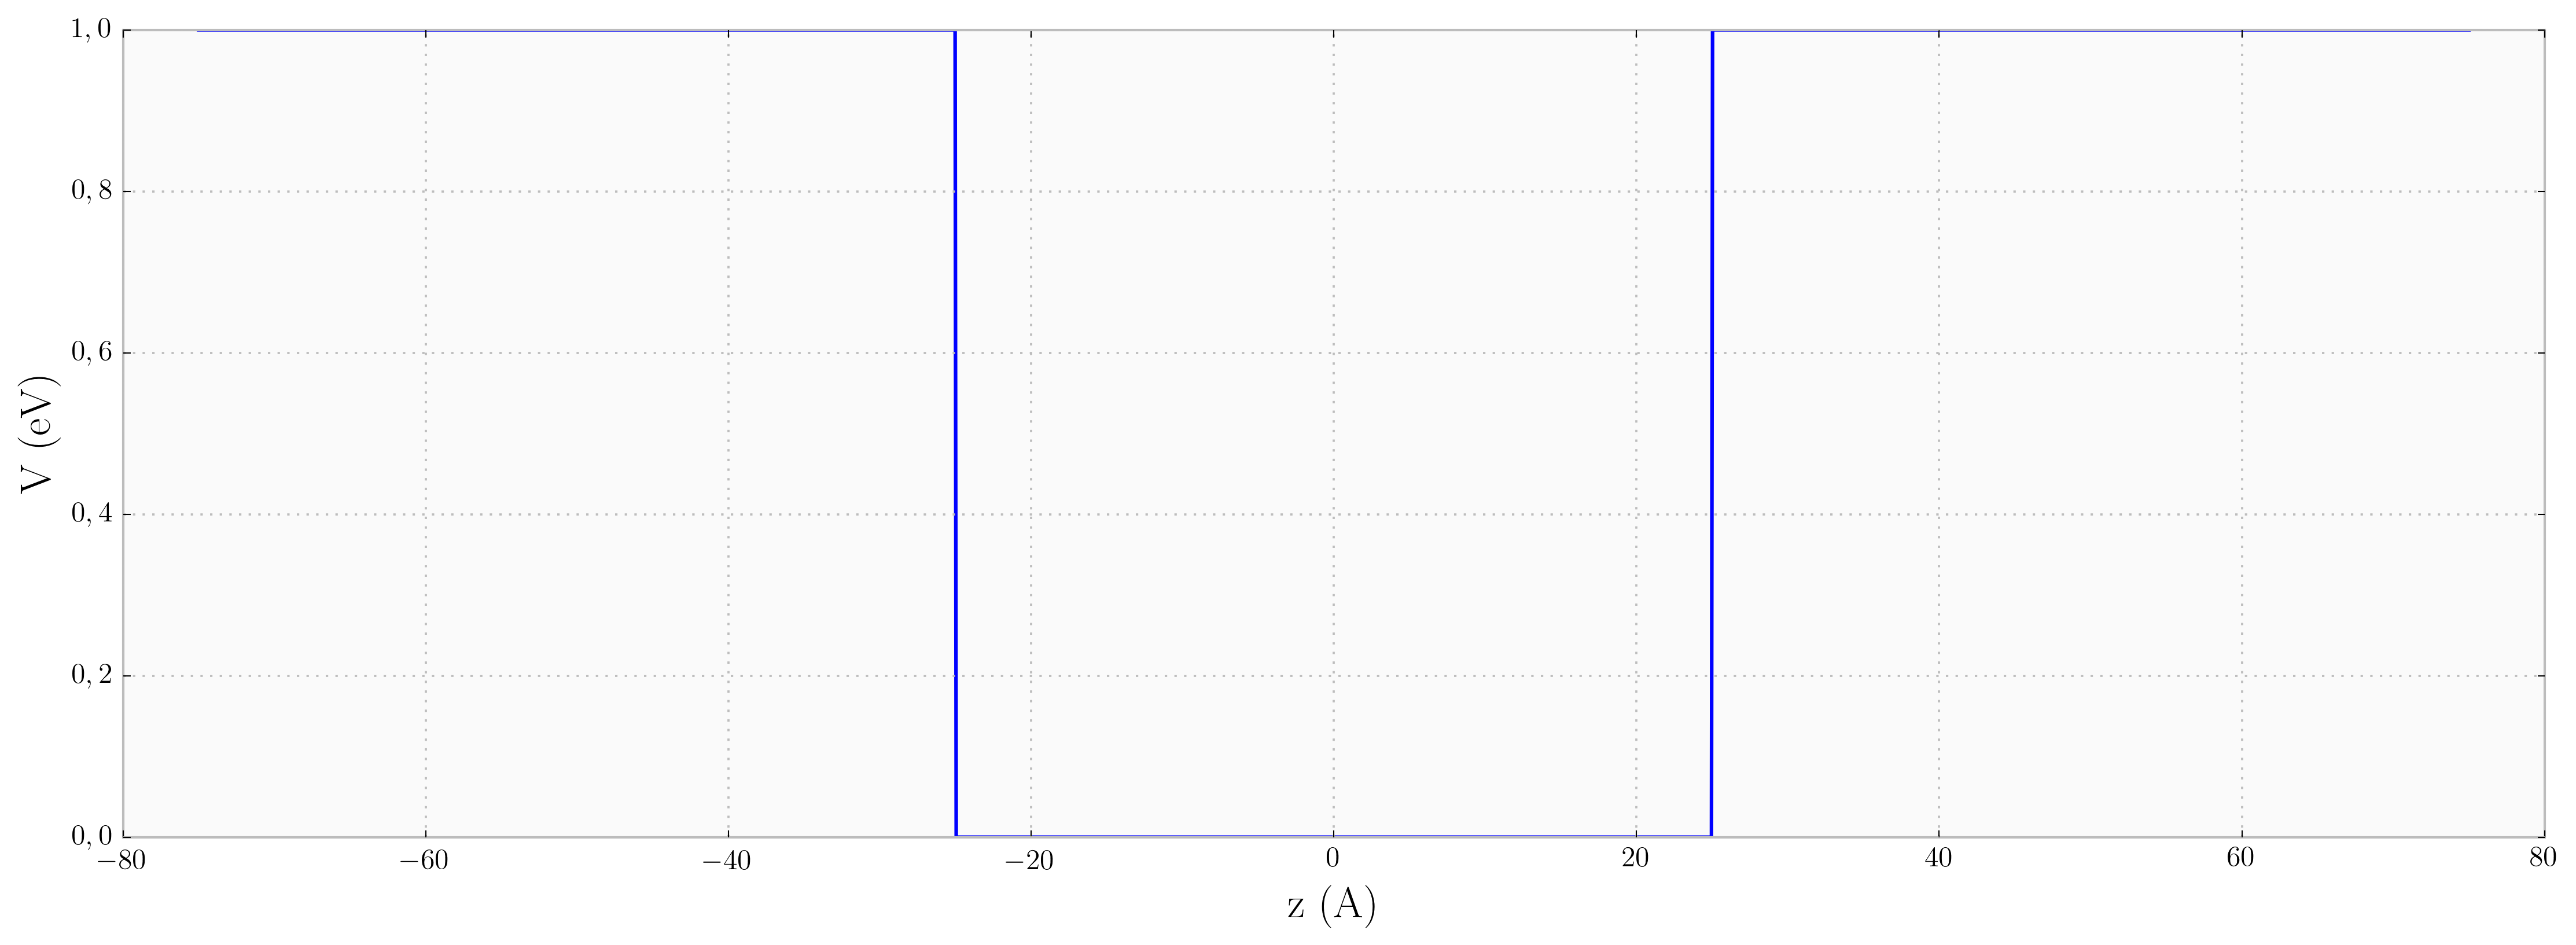

In [38]:
fix, ax = plt.subplots(1,1, figsize=(18,6))
ax.plot(poco_50.z_ang, poco_50.v_ev)
ax.set_xlabel(r'z (A)')
ax.set_ylabel(r'V (eV)')
plt.show()

In [39]:
poco_50.evolucao_imaginaria(precision=1e-4)

Energy [0]:
                                Numeric=1.2951868994e-02
                                Analytic=1.2937397611e-02
                                iterations=33000
Energy [1]:
                                Numeric=5.1752222957e-02
                                Analytic=5.1699753783e-02
                                iterations=24000
Energy [2]:
                                Numeric=1.1623530904e-01
                                Analytic=1.1612905356e-01
                                iterations=16000
Energy [3]:
                                Numeric=2.0610841151e-01
                                Analytic=2.0592968138e-01
                                iterations=14000
Energy [4]:
                                Numeric=3.2087362193e-01
                                Analytic=3.2060263426e-01
                                iterations=11000
Energy [5]:
                                Numeric=4.5967820296e-01
                                Analytic=4.59298486

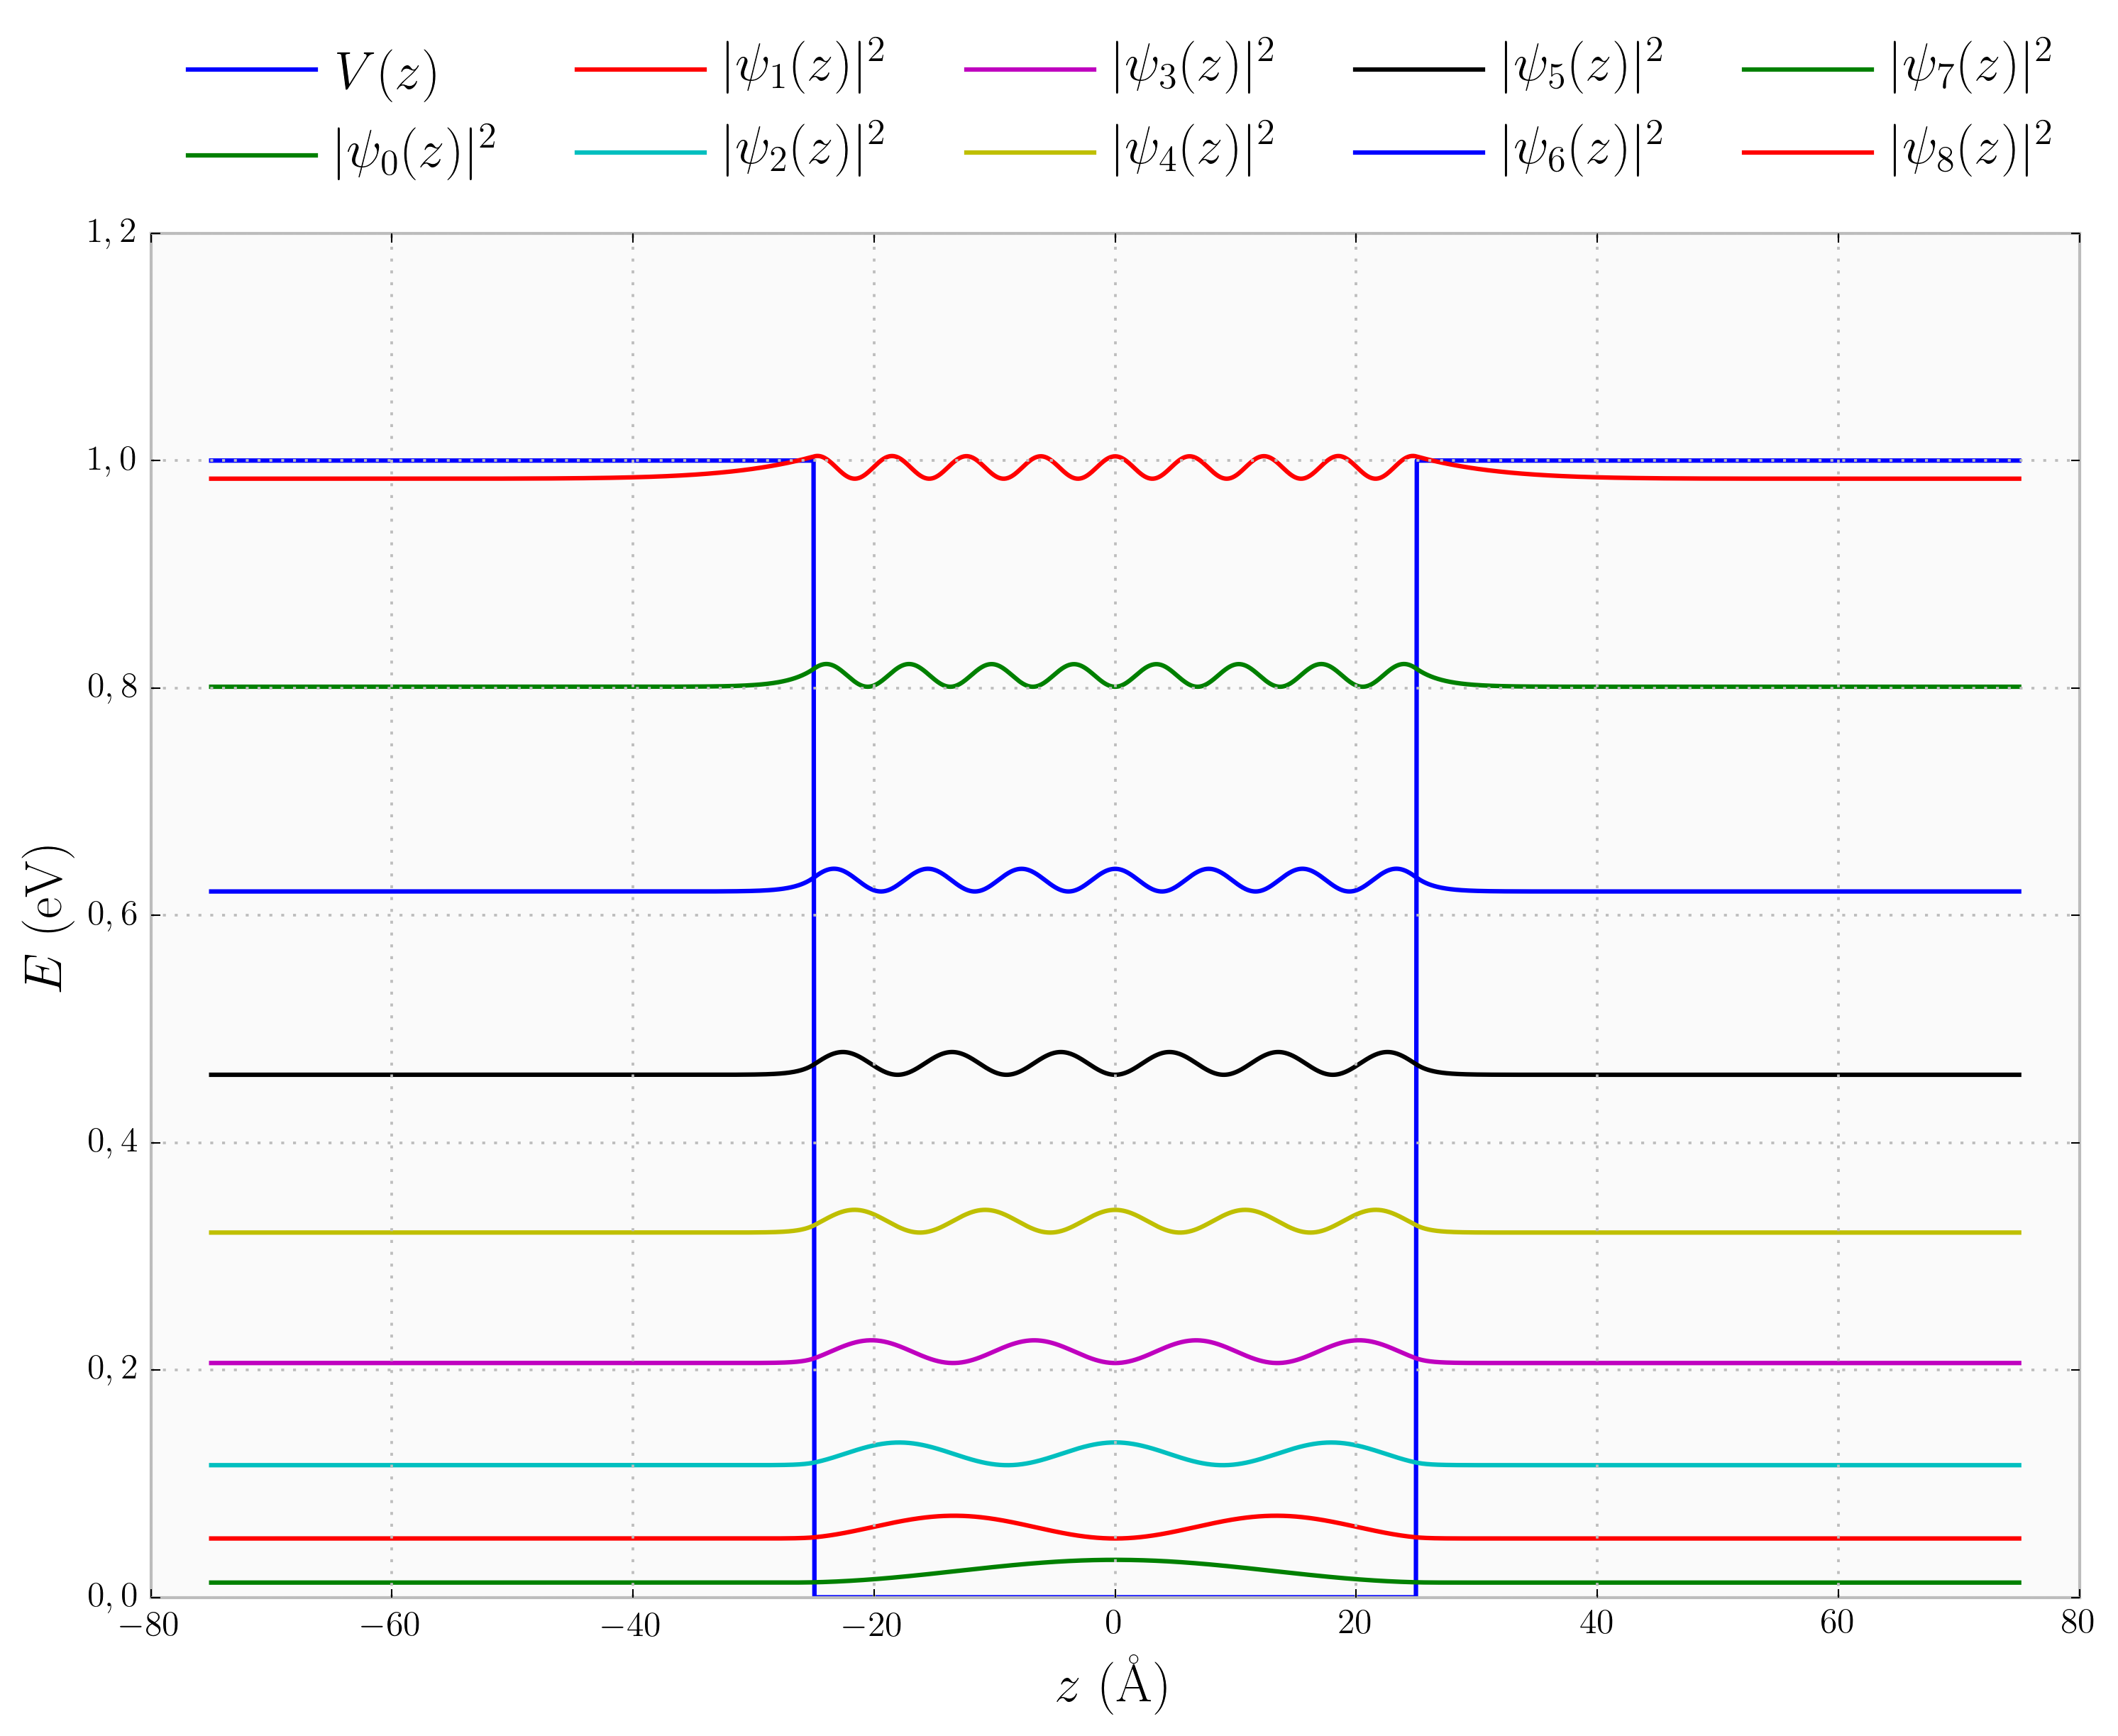

In [61]:
fix, ax = plt.subplots(1,1)
vsize = np.ptp(poco_50.v_ev)
ax.plot(poco_50.z_ang, poco_50.v_ev, label=r'$V(z)$')

for i, es in enumerate(poco_50.eigenstates):
    psi2 = np.abs(es)**2
    psi2 = 0.02 * psi2 * vsize / np.max(psi2) + poco_50.eigenvalues[i]
    ax.plot(poco_50.z_ang, psi2, label=r'$|\psi_{%d} (z)|^2$' % i)
    
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'$E$ (eV)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=5)
plt.savefig('figuras/poco_quantico_numerico_autoestados.png', bbox_inches='tight')